In [1]:
# %pip install pandas numpy seaborn matplotlib xgboost scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import graphviz

from sklearn.preprocessing import OrdinalEncoder, Normalizer
from sklearn.metrics import (balanced_accuracy_score,
                             recall_score, f1_score,
                             precision_score,
                             r2_score,
                             roc_curve,
                             auc)
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None)

## Import the dataset
In this Notebook we are working with the UGR'16 dataset.  
We will not use the entire dataset but just a sample of the [July 2016 dataset](https://nesg.ugr.es/nesg-ugr16/july.php#INI). We have recovered one line out of 50 as the sample.

In [2]:
path = "D:/Network anomoly detection/sample_july_final.pkl"
dataset = pd.read_pickle(path)

## Dataset structure

We are going to analyse the structure of the dataset and if necessary reformat the dataset.

In [3]:
dataset.head()

dateTime  duration           srcIP            dstIP  srcPort  dstPort  \
0     49415     2.600  42.219.153.147    216.58.97.118       80    51414   
1     49421     0.268     216.33.72.2   42.219.156.211    65527      443   
2     49427     0.000    143.72.4.250   42.219.154.176       53    43621   
3     49432     0.556  42.219.154.129  106.150.228.197       80     8116   
4     49437     6.228  223.80.232.137   42.219.154.154    65431       80   

  protocol    flag  forwardingStatus  tos  packets  bytes       label  
0      TCP  .AP.SF                 0    0       56  78899  background  
1      TCP  .AP..F                 0    0        8   1328  background  
2      UDP  .A....                 0    0        1    141  background  
3      TCP  .A..SF                 0    0        3    128  background  
4      TCP  .A..SF                 0    0        4    172  background

In [4]:
dataset.shape

(107894, 13)

We can see that the dataset has no column name and that there are 10,789,816 rows and 13 columns.  
In the page 8 section *D. Dataset Preprocessing and Availability* of the [UGR’16 paper](https://nesg.ugr.es/nesg-ugr16/dataset_AuthorVersionFinal.pdf) we can find the name of the columns. <br> <br>

![URG'16](images/column_name.png) <br> <br>

So we are going to rename the columns with the following names:
- Timestamp of the end of a flow: **dateTime**
- Duration of the flow: **duration**
- Source IP Address : **srcIP**
- Destination IP Address: **dstIP**
- Source Port: **srcPort**
- Destination Port: **dstPort**
- Protocol: **protocol**
- Flag: **flag**
- Forwarding status: **forwardingStatus**
- Type of Service (ToS) byte: **tos**
- Packets exchanged: **packets**
- Bytes exchanged: **bytes**
- Label: **label**

In [5]:
dataset.columns = ['dateTime', 'duration', 'srcIP', 'dstIP', 'srcPort', 'dstPort',
                   'protocol', 'flag', 'forwardingStatus', 'tos', 'packets', 'bytes', 'label']

In [6]:
dataset.head()

dateTime  duration           srcIP            dstIP  srcPort  dstPort  \
0     49415     2.600  42.219.153.147    216.58.97.118       80    51414   
1     49421     0.268     216.33.72.2   42.219.156.211    65527      443   
2     49427     0.000    143.72.4.250   42.219.154.176       53    43621   
3     49432     0.556  42.219.154.129  106.150.228.197       80     8116   
4     49437     6.228  223.80.232.137   42.219.154.154    65431       80   

  protocol    flag  forwardingStatus  tos  packets  bytes       label  
0      TCP  .AP.SF                 0    0       56  78899  background  
1      TCP  .AP..F                 0    0        8   1328  background  
2      UDP  .A....                 0    0        1    141  background  
3      TCP  .A..SF                 0    0        3    128  background  
4      TCP  .A..SF                 0    0        4    172  background

In [7]:
dataset.label.unique()
print(dataset['label'].unique())

['background' 'blacklist' 'anomaly-spam' 'dos' 'scan11' 'scan44'
 'nerisbotnet']


The column *label* indicates if there were an anomaly or not. There are 8 different values (*background, blacklist, anomaly-spam, dos, scan11, scan44, nerisbotnet, anomaly-sshscan*).

The attack labeled *blacklist* is a bit special. In this case, we recognize the attack based on a list of blacklisted Ips. Thus, we will remove this attack from the dataset.

In [8]:
dataset = dataset[dataset.label != "blacklist"].reset_index().drop("index", axis=1)
dataset.head()

dateTime  duration           srcIP            dstIP  srcPort  dstPort  \
0     49415     2.600  42.219.153.147    216.58.97.118       80    51414   
1     49421     0.268     216.33.72.2   42.219.156.211    65527      443   
2     49427     0.000    143.72.4.250   42.219.154.176       53    43621   
3     49432     0.556  42.219.154.129  106.150.228.197       80     8116   
4     49437     6.228  223.80.232.137   42.219.154.154    65431       80   

  protocol    flag  forwardingStatus  tos  packets  bytes       label  
0      TCP  .AP.SF                 0    0       56  78899  background  
1      TCP  .AP..F                 0    0        8   1328  background  
2      UDP  .A....                 0    0        1    141  background  
3      TCP  .A..SF                 0    0        3    128  background  
4      TCP  .A..SF                 0    0        4    172  background

We will consider the label *background* as normal and the others (*anomaly-spam, dos, scan11, scan44, nerisbotnet, anomaly-sshscan*) as anomalies.  
Normal behaviours will have the value 0 and the normal ones the value 1.

In [9]:
dataset.label = np.where(dataset.label == "background", 0, 1)

### Columns deletion

In [10]:
dataset.forwardingStatus.unique()

array([0])

We can see that the column *forwardingStatus* has a unique value, so we can remove this column.

In [10]:
dataset = dataset.drop(columns=["forwardingStatus"])

Also we are going to remove the *srcIP* and *dstIP* columns.

In [11]:
dataset = dataset.drop(columns=["srcIP", "dstIP"])

### Transformation of the dateTime column

We are going to encode the dateTime column in order to use it.

In [12]:
dataset.dateTime = dataset.dateTime.astype("datetime64").apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

ValueError: The 'datetime64' dtype has no unit. Please pass in 'datetime64[ns]' instead.

### Check if there are null values

In [13]:
dataset.isna().values.any()

np.False_

We can see that there are no null values in the dataset.

### Final dataset

In [14]:
dataset.head()

dateTime  duration  srcPort  dstPort protocol    flag  tos  packets  bytes  \
0     49415     2.600       80    51414      TCP  .AP.SF    0       56  78899   
1     49421     0.268    65527      443      TCP  .AP..F    0        8   1328   
2     49427     0.000       53    43621      UDP  .A....    0        1    141   
3     49432     0.556       80     8116      TCP  .A..SF    0        3    128   
4     49437     6.228    65431       80      TCP  .A..SF    0        4    172   

   label  
0      0  
1      0  
2      0  
3      0  
4      0

So our final dataset has only 10 columns: *dateTime, duration, srcPort, dstPort, protocol, flag, tos, packets, bytes, label*

## Data analysis

In this section we will analyse the dataset.

In [15]:
dataset.label.value_counts(normalize=True) * 100

label
0    98.927659
1     1.072341
Name: proportion, dtype: float64

We can see that we have an unbalanced dataset. Indeed 98.9% of our data corresponds to a normal traffic and only 1.1% of the data to anomalies.
The robustness of our model will be greatly impacted by its capacity to detect anomalies.

<br>

We will now compare the distribution of the data according to their label.

In [16]:
fraud_data = dataset[dataset.label == 1]
normal_data = dataset[dataset.label == 0]

In [17]:
fraud_data.describe()

dateTime     duration       srcPort       dstPort          tos  \
count   1154.000000  1154.000000   1154.000000   1154.000000  1154.000000   
mean   34722.523397     0.342873  19211.845754  10381.758232     0.034662   
std    24484.749893     1.894688  21971.589220  15748.617330     1.177490   
min        0.000000     0.000000      0.000000      7.000000     0.000000   
25%    13912.500000     0.000000     80.000000     80.000000     0.000000   
50%    24715.000000     0.000000   8586.000000   3278.000000     0.000000   
75%    57659.500000     0.000000  40898.250000  13273.750000     0.000000   
max    86053.000000    30.712000  65100.000000  64647.000000    40.000000   

           packets         bytes   label  
count  1154.000000   1154.000000  1154.0  
mean      2.079723    201.697574     1.0  
std       9.391396   1351.652584     0.0  
min       1.000000     40.000000     1.0  
25%       1.000000     40.000000     1.0  
50%       1.000000     44.000000     1.0  
75%       2.000000    200.000000     1.0  
max     314.000000  35265.000000     1.0

In [18]:
normal_data.describe()

dateTime       duration        srcPort        dstPort  \
count  106461.000000  106461.000000  106461.000000  106461.000000   
mean    47139.957863       4.819216   24016.407407   20339.818694   
std     24493.665201      24.437846   24014.846294   24036.889743   
min         1.000000       0.000000       0.000000       0.000000   
25%     27208.000000       0.000000      80.000000      80.000000   
50%     50133.000000       0.256000   16623.000000    1055.000000   
75%     67828.000000       2.988000   49343.000000   47018.000000   
max     86398.000000     360.004000   65534.000000   65535.000000   

                 tos       packets         bytes     label  
count  106461.000000  1.064610e+05  1.064610e+05  106461.0  
mean        9.591362  3.551966e+01  3.527109e+04       0.0  
std        23.668665  5.173821e+03  7.512372e+06       0.0  
min         0.000000  1.000000e+00  2.800000e+01       0.0  
25%         0.000000  1.000000e+00  8.600000e+01       0.0  
50%         0.000000  2.000000e+00  1.970000e+02       0.0  
75%         0.000000  8.000000e+00  1.145000e+03       0.0  
max       216.000000  1.664992e+06  2.435807e+09       0.0

In [19]:
def distribution(dataset_normal, dataset_anomaly, feature, head=10):
    a = dataset_normal[feature].value_counts(normalize=True).head(head) * 100
    b = dataset_anomaly[feature].value_counts(normalize=True).head(head) * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    m = max(max(a), max(b))
    
    a.plot.bar(title="Normal traffic", ax=ax1)
    ax1.set_ylim(0, m * 1.1)
    ax1.set_xlabel(feature)
    ax1.set_ylabel("% of occurrence")

    b.plot.bar(title="Fraudulent traffic", ax=ax2)
    ax2.set_ylim(0, m * 1.1)
    ax2.set_xlabel(feature)
    ax2.set_ylabel("% of occurrence")
    
    plt.show()
    
    return a, b

def compare_distribution(normal, fraud, feature):
    print(f"Comparison between normal and fraudulent traffic for the: {feature}")
    print(f"Normal traffic: {round(normal.sum(), 3)}% - Fraudulent traffic: {round(fraud.sum(), 3)}%", end="\n\n")
    
    for i in fraud.index:
        if i in normal.index:
            print(f"flag = {i}: Fraud = {round(fraud[i], 3)}% | Normal = {round(normal[i], 3)}%")
        else:
            print(f"flag = {i}: Fraud = {round(fraud[i], 3)}%")

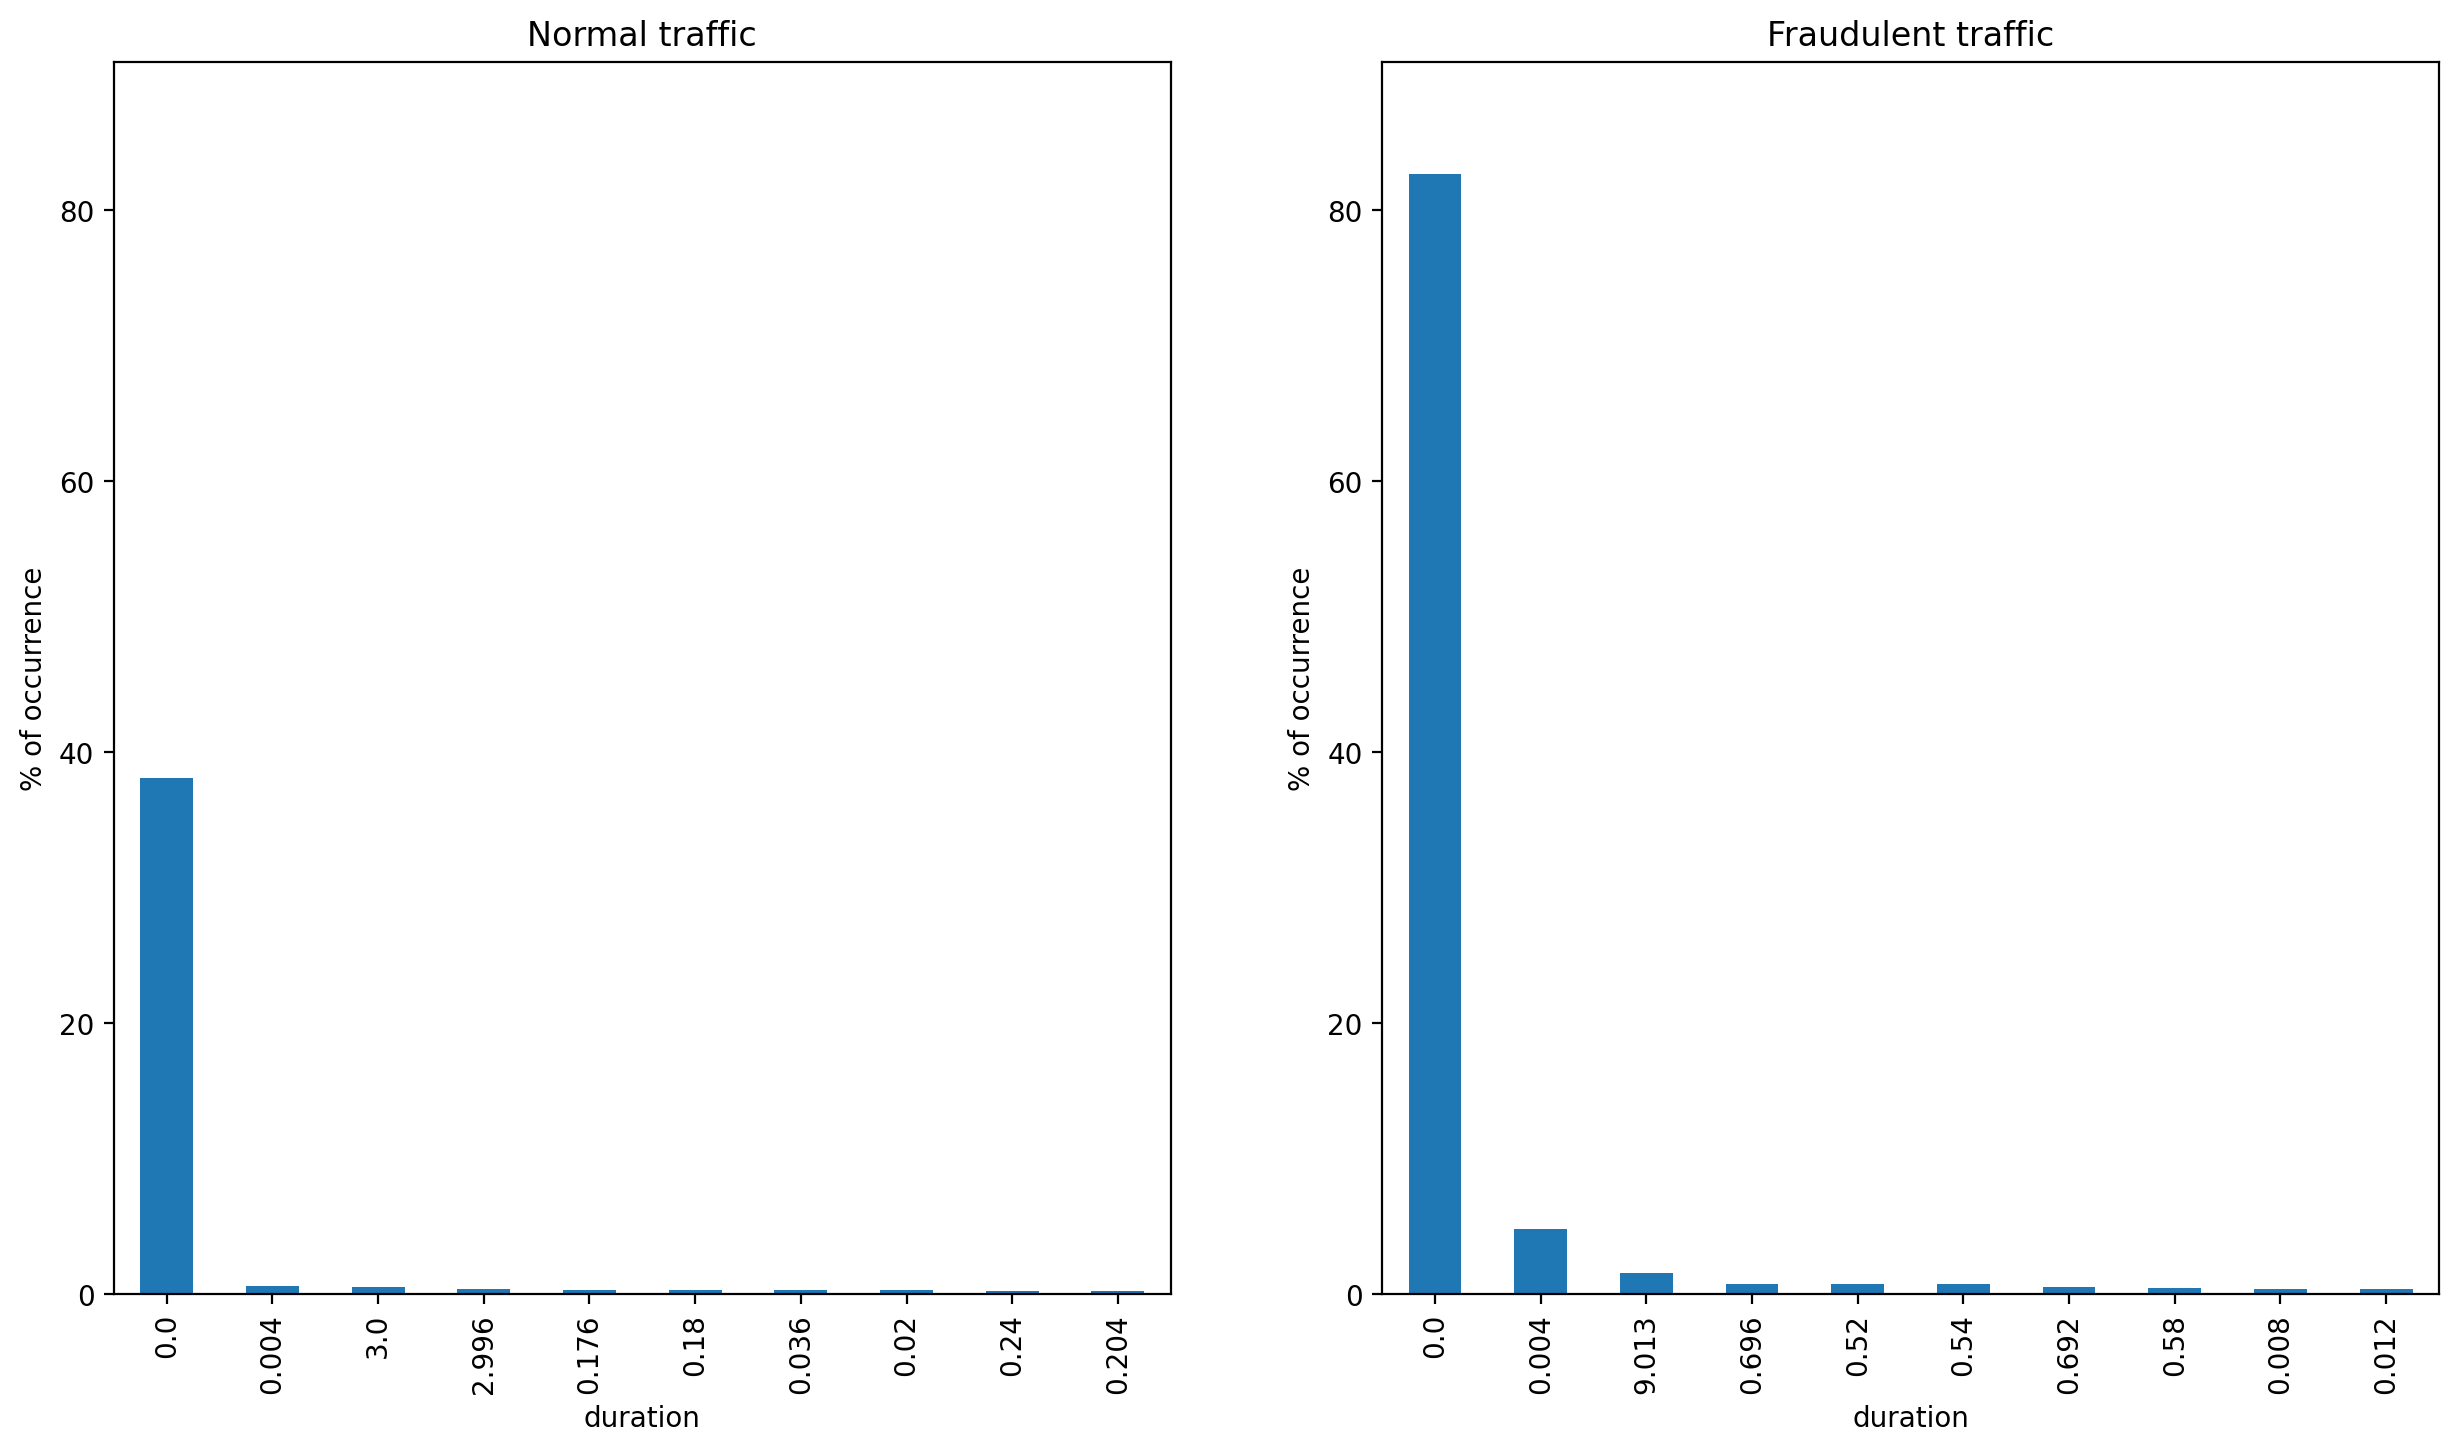

In [20]:
_ = distribution(normal_data, fraud_data, "duration")

We can observe that more than 80% of the duration of the flow of the anomalies was 0 seconde

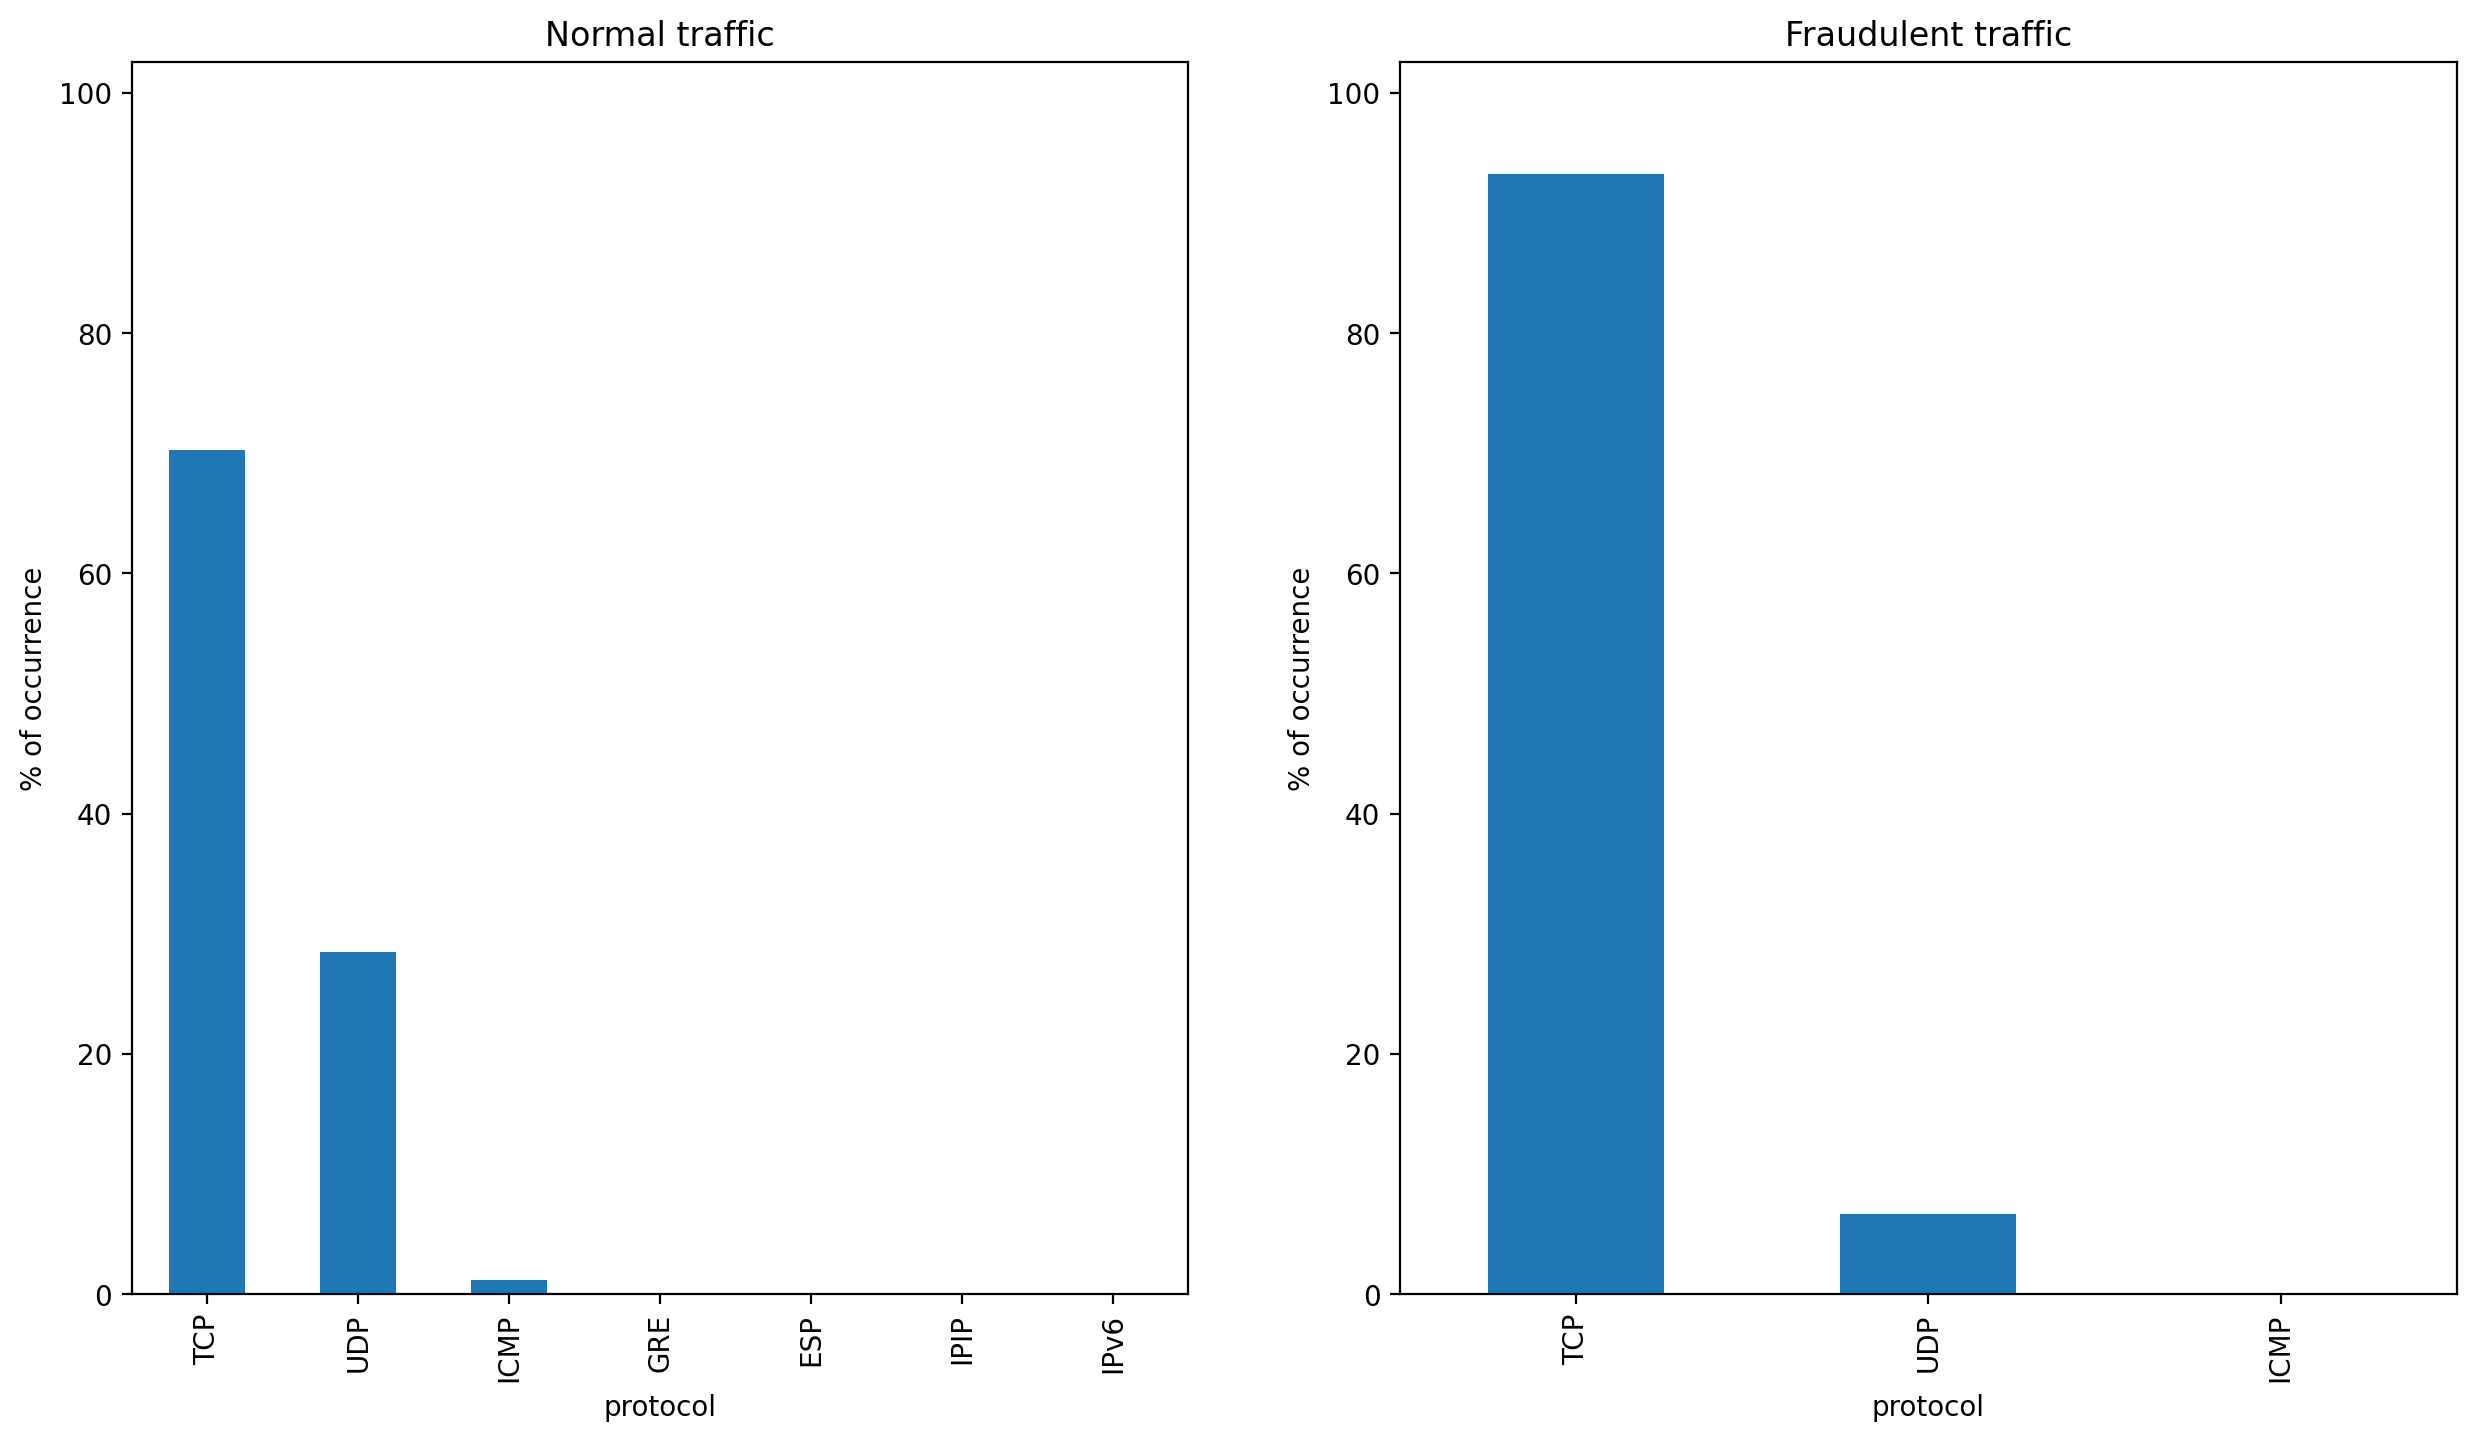

In [21]:
_ = distribution(normal_data, fraud_data, "protocol")

100% of the fraudulent traffic uses the protocols TCP, UDP and ICMP

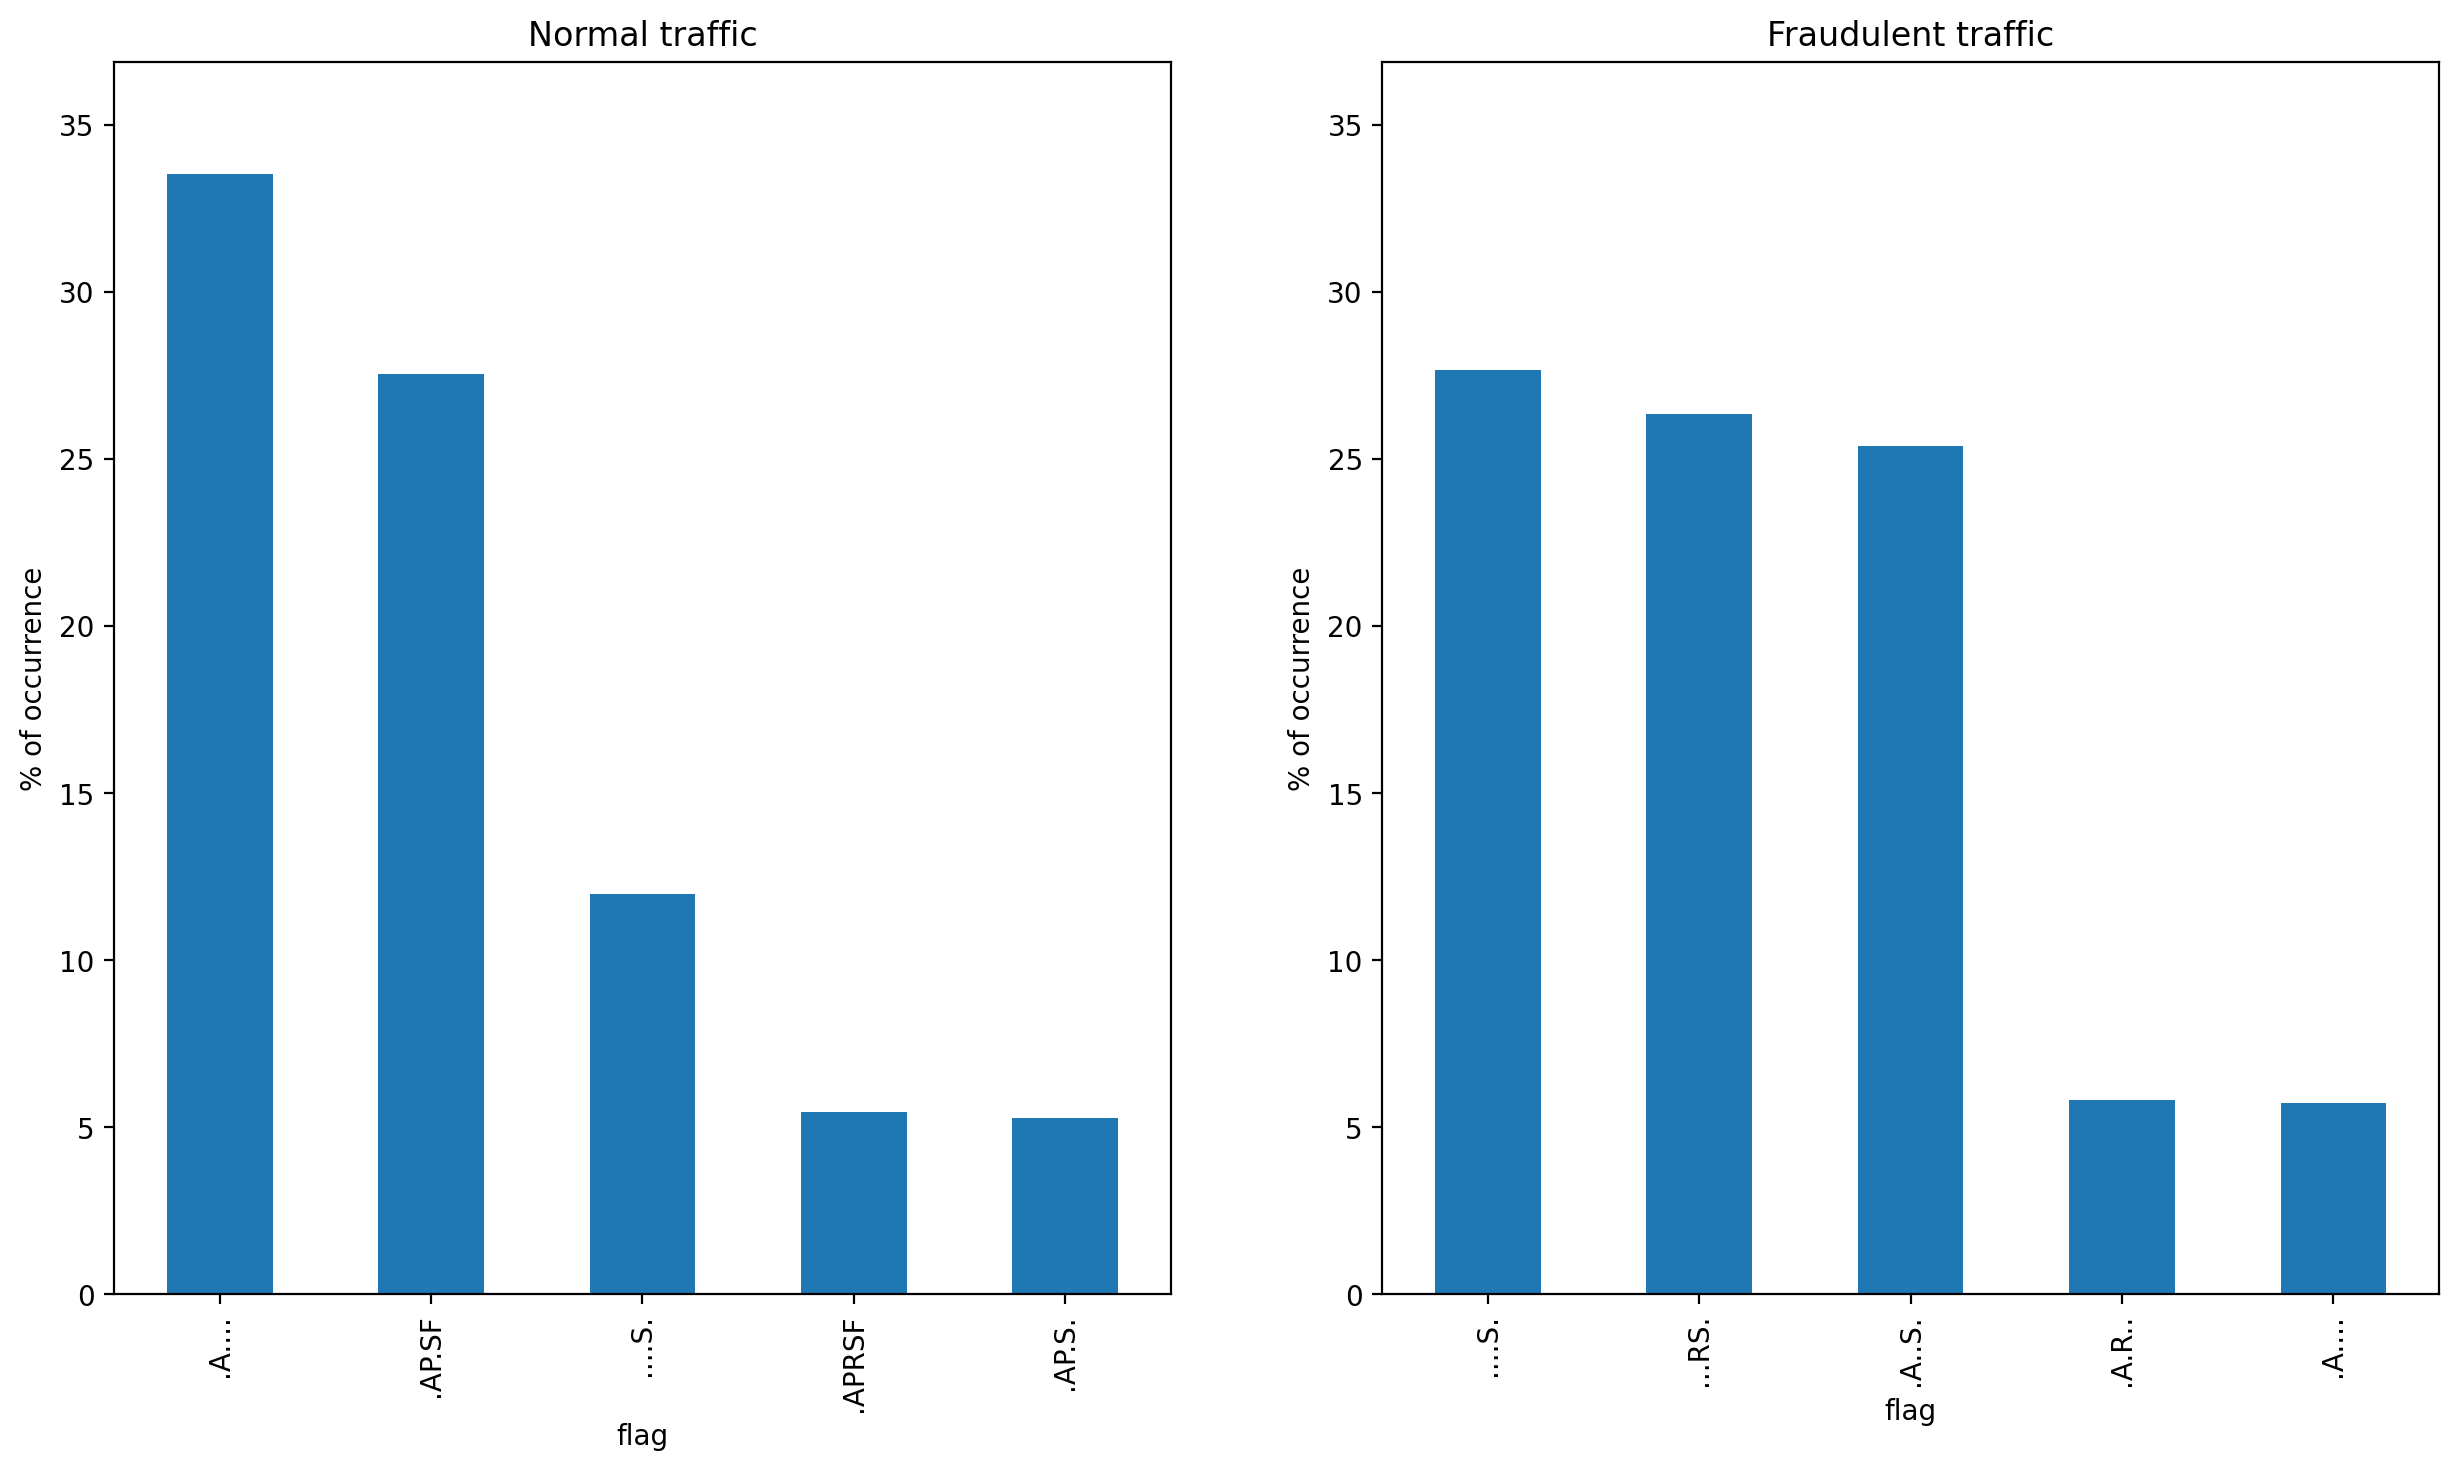

In [22]:
normal_flag, fraud_flag = distribution(normal_data, fraud_data, "flag", 5)

In [23]:
compare_distribution(normal_flag, fraud_flag, "flag")

Comparison between normal and fraudulent traffic for the: flag
Normal traffic: 83.734% - Fraudulent traffic: 90.901%

flag = ....S.: Fraud = 27.643% | Normal = 11.972%
flag = ...RS.: Fraud = 26.343%
flag = .A..S.: Fraud = 25.39%
flag = .A.R..: Fraud = 5.806%
flag = .A....: Fraud = 5.719% | Normal = 33.522%


We observe that 90% of the fraudulent traffic uses 5 different flags.

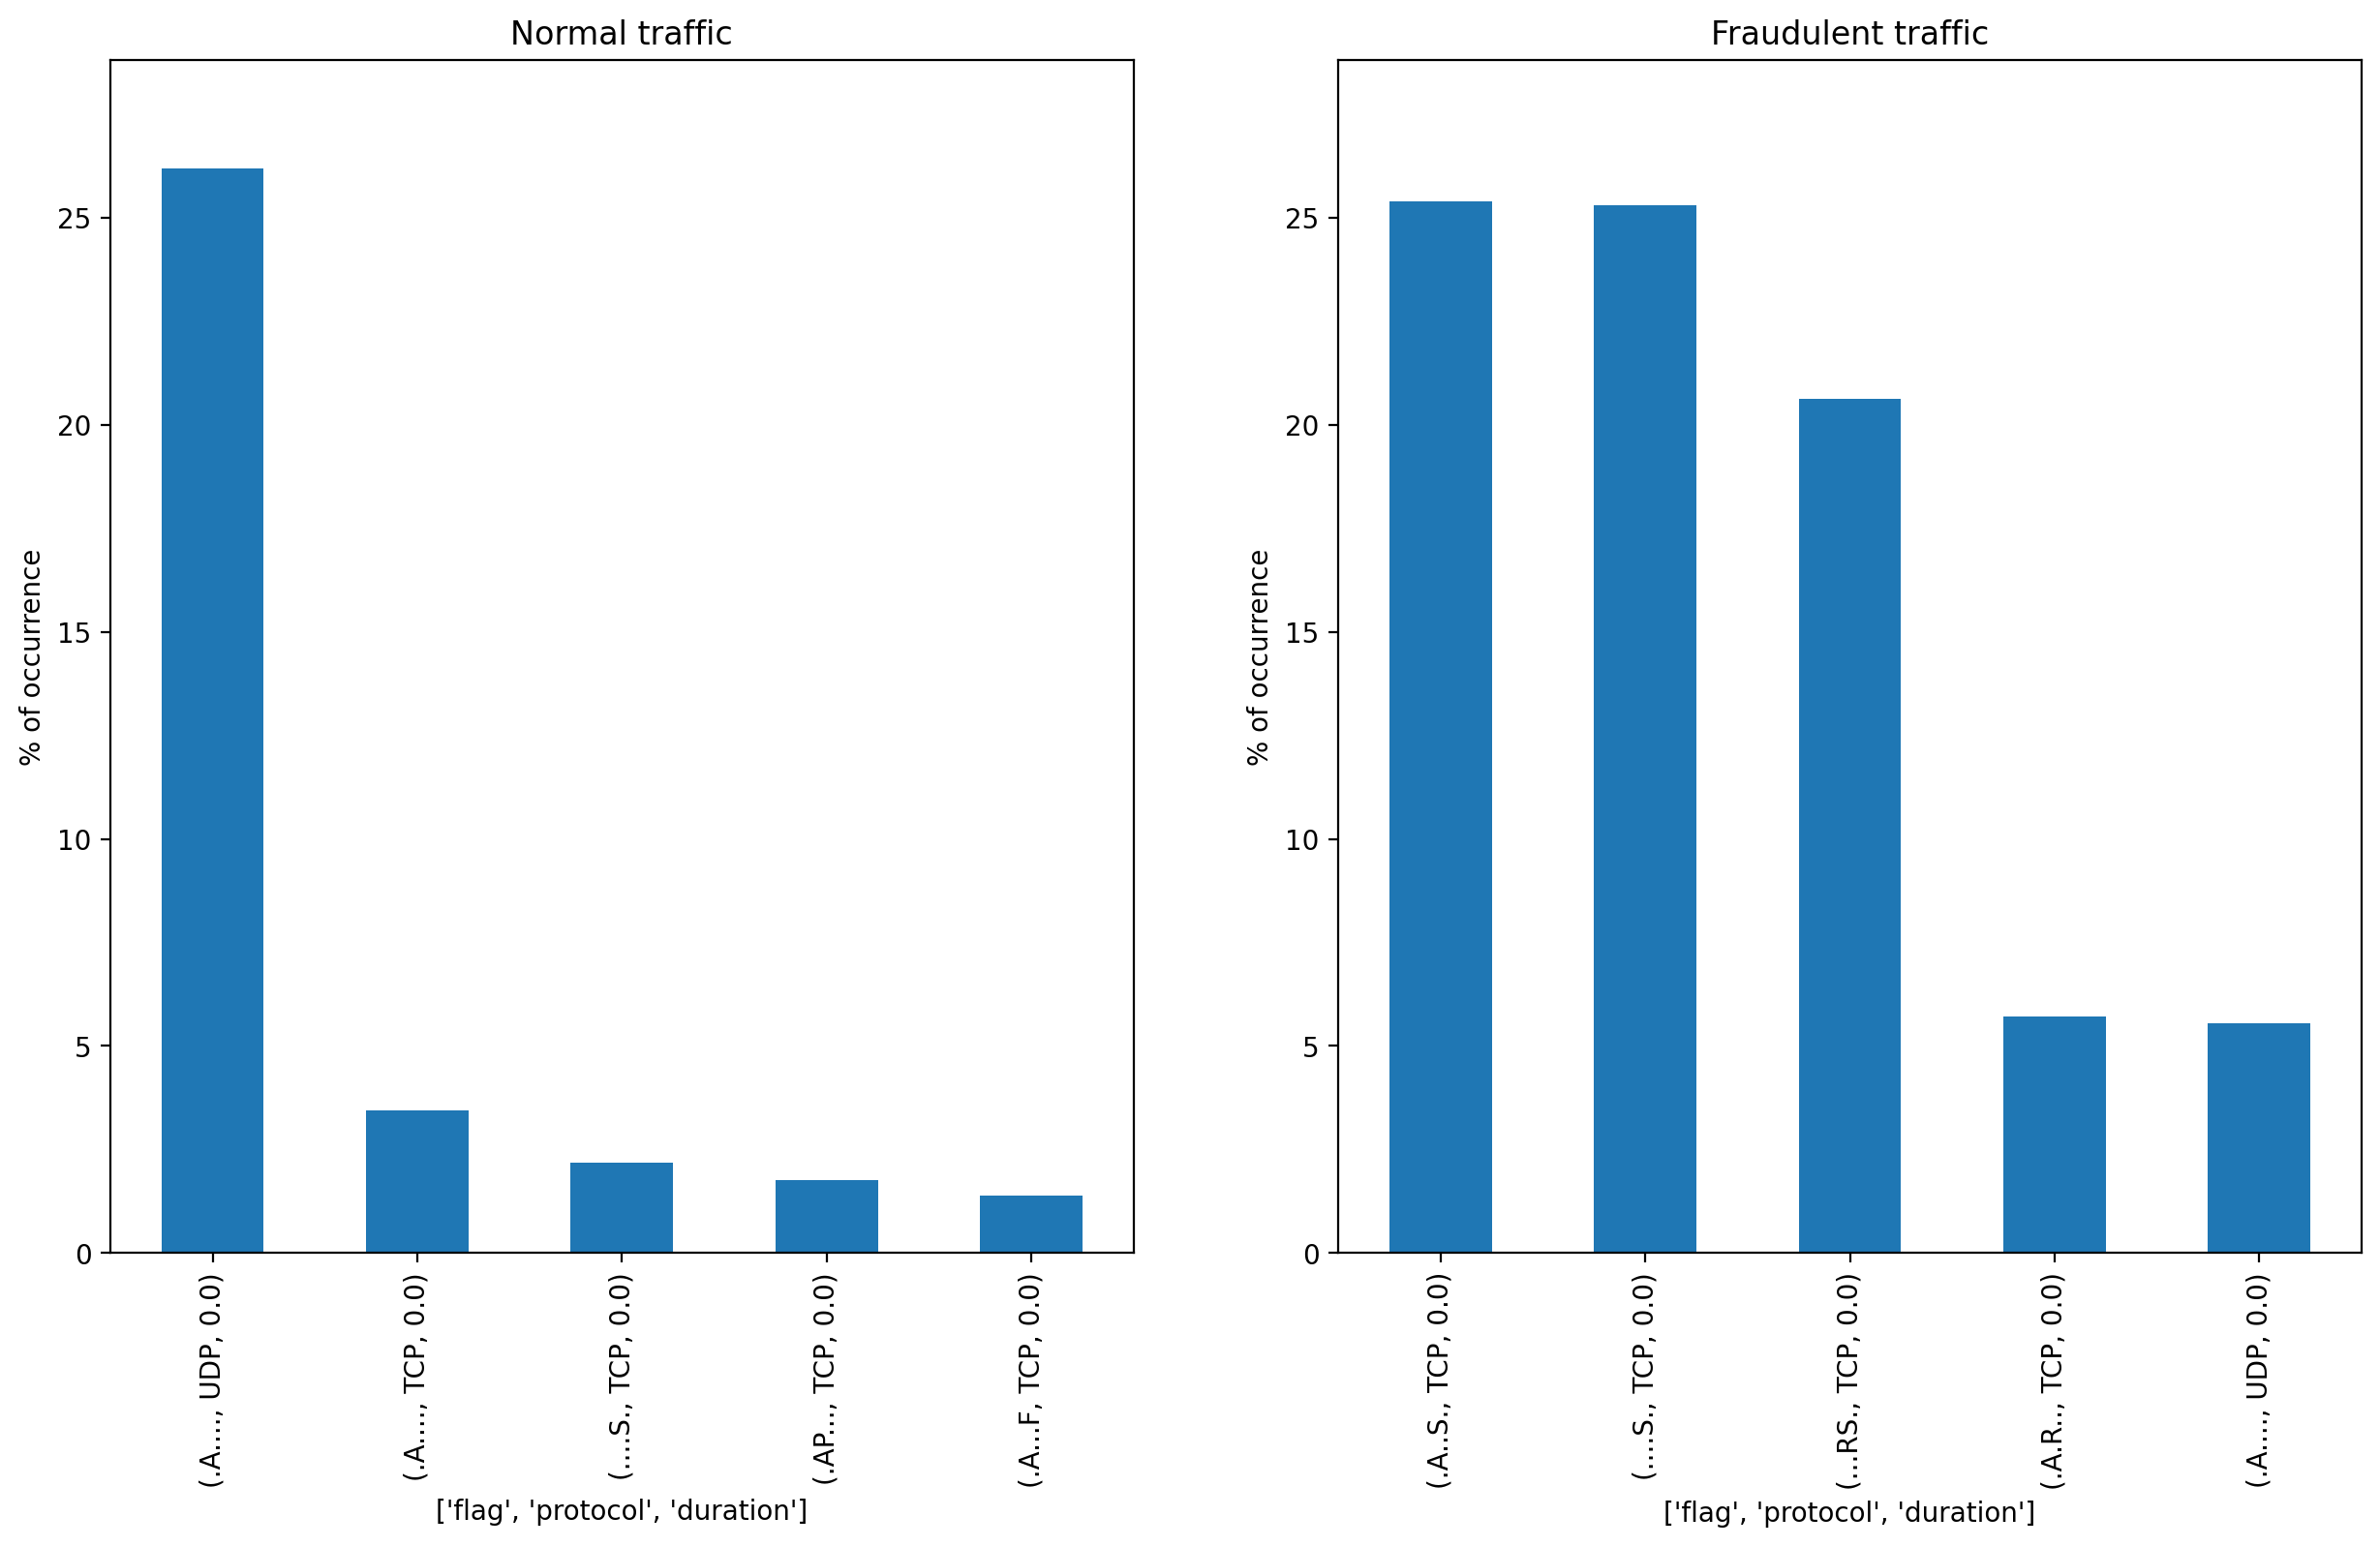

In [24]:
normal_mul, fraud_mul = distribution(normal_data, fraud_data, ["flag", "protocol", "duration"], 5)

In [25]:
compare_distribution(normal_mul, fraud_mul, ["flag", "protocol", "duration"])

Comparison between normal and fraudulent traffic for the: ['flag', 'protocol', 'duration']
Normal traffic: 34.95% - Fraudulent traffic: 82.582%

flag = ('.A..S.', 'TCP', 0.0): Fraud = 25.39%
flag = ('....S.', 'TCP', 0.0): Fraud = 25.303% | Normal = 2.174%
flag = ('...RS.', 'TCP', 0.0): Fraud = 20.624%
flag = ('.A.R..', 'TCP', 0.0): Fraud = 5.719%
flag = ('.A....', 'UDP', 0.0): Fraud = 5.546% | Normal = 26.184%


With only 5 combinations of flags, protocol and duration we can detect 82% of the fraudulent traffic.

In [26]:
def distribution_hist(dataset_normal, dataset_anomaly, feature, bins=100):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    
    dataset_normal[feature].hist(ax=ax1, bins=bins)
    dataset_anomaly[feature].hist(ax=ax2, bins=bins)
    
    ax1.set_title("Normal traffic")
    ax1.set_xlabel(feature)
    ax1.set_ylabel("Number of occurrence")
    
    ax2.set_title("Fraudulent traffic")
    ax2.set_xlabel(feature)
    ax2.set_ylabel("Number of occurrence")
    
    plt.show()

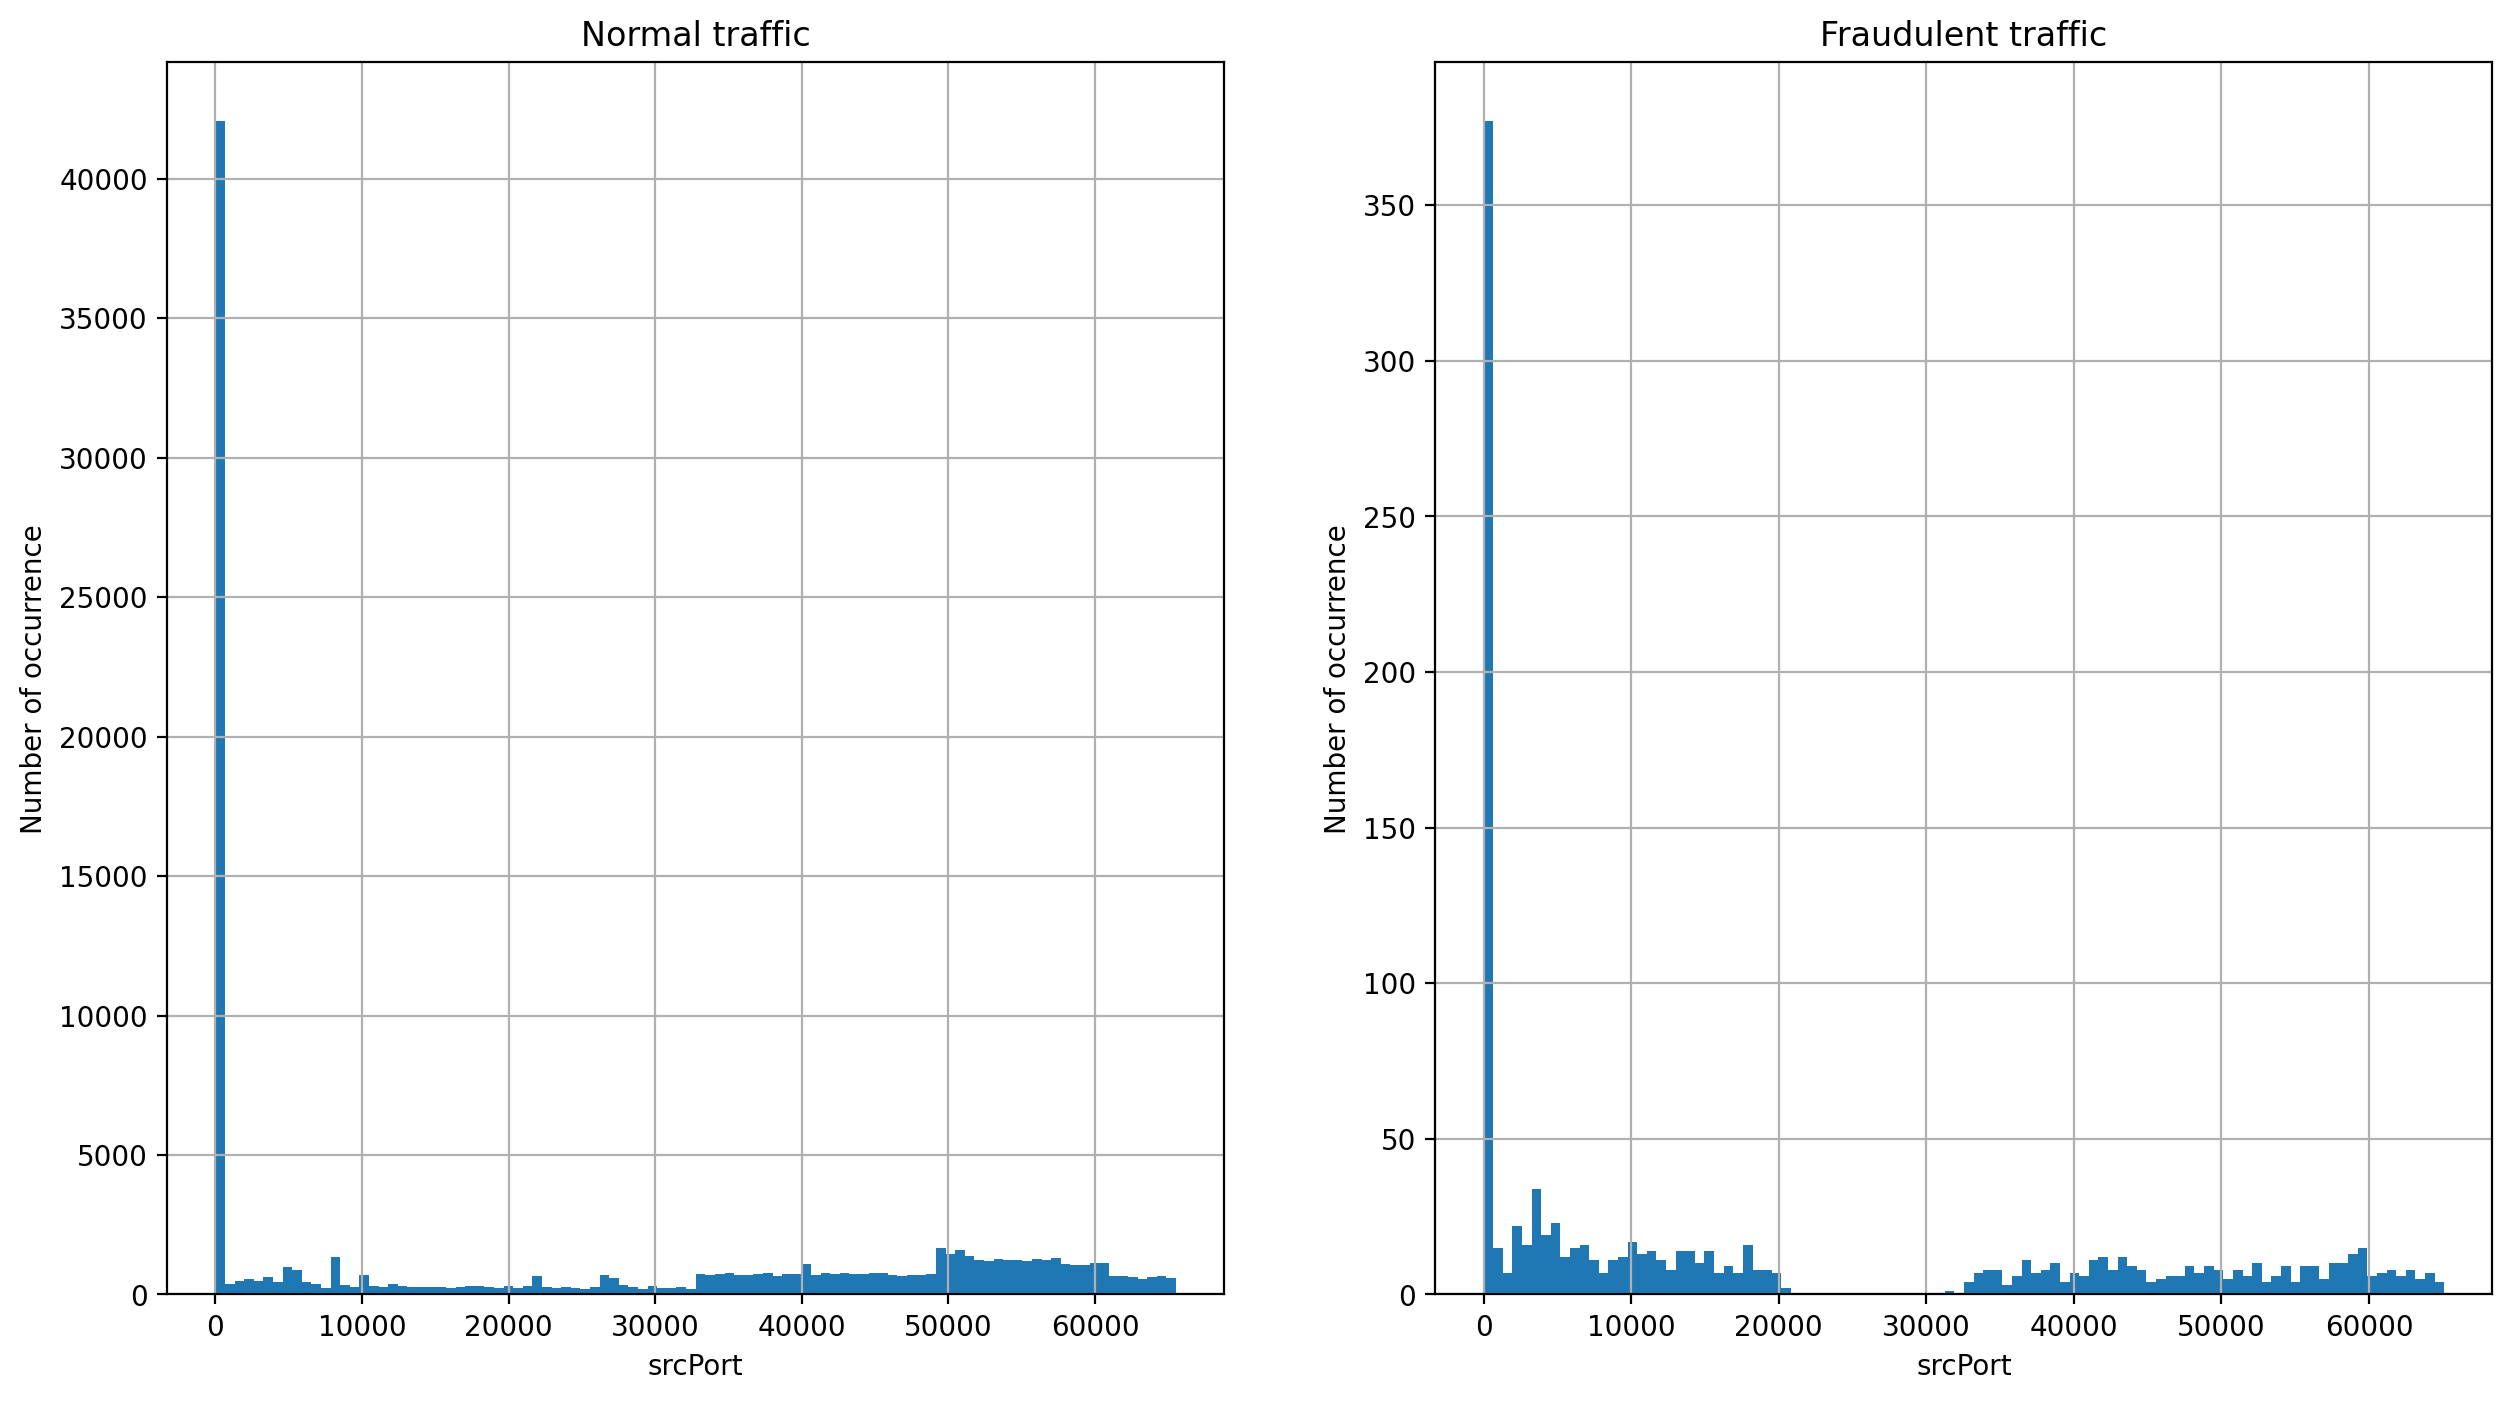

In [27]:
distribution_hist(normal_data, fraud_data, "srcPort", 100)

We can observe that there is almost no fraudulent traffic between source ports 20000 and 32000.

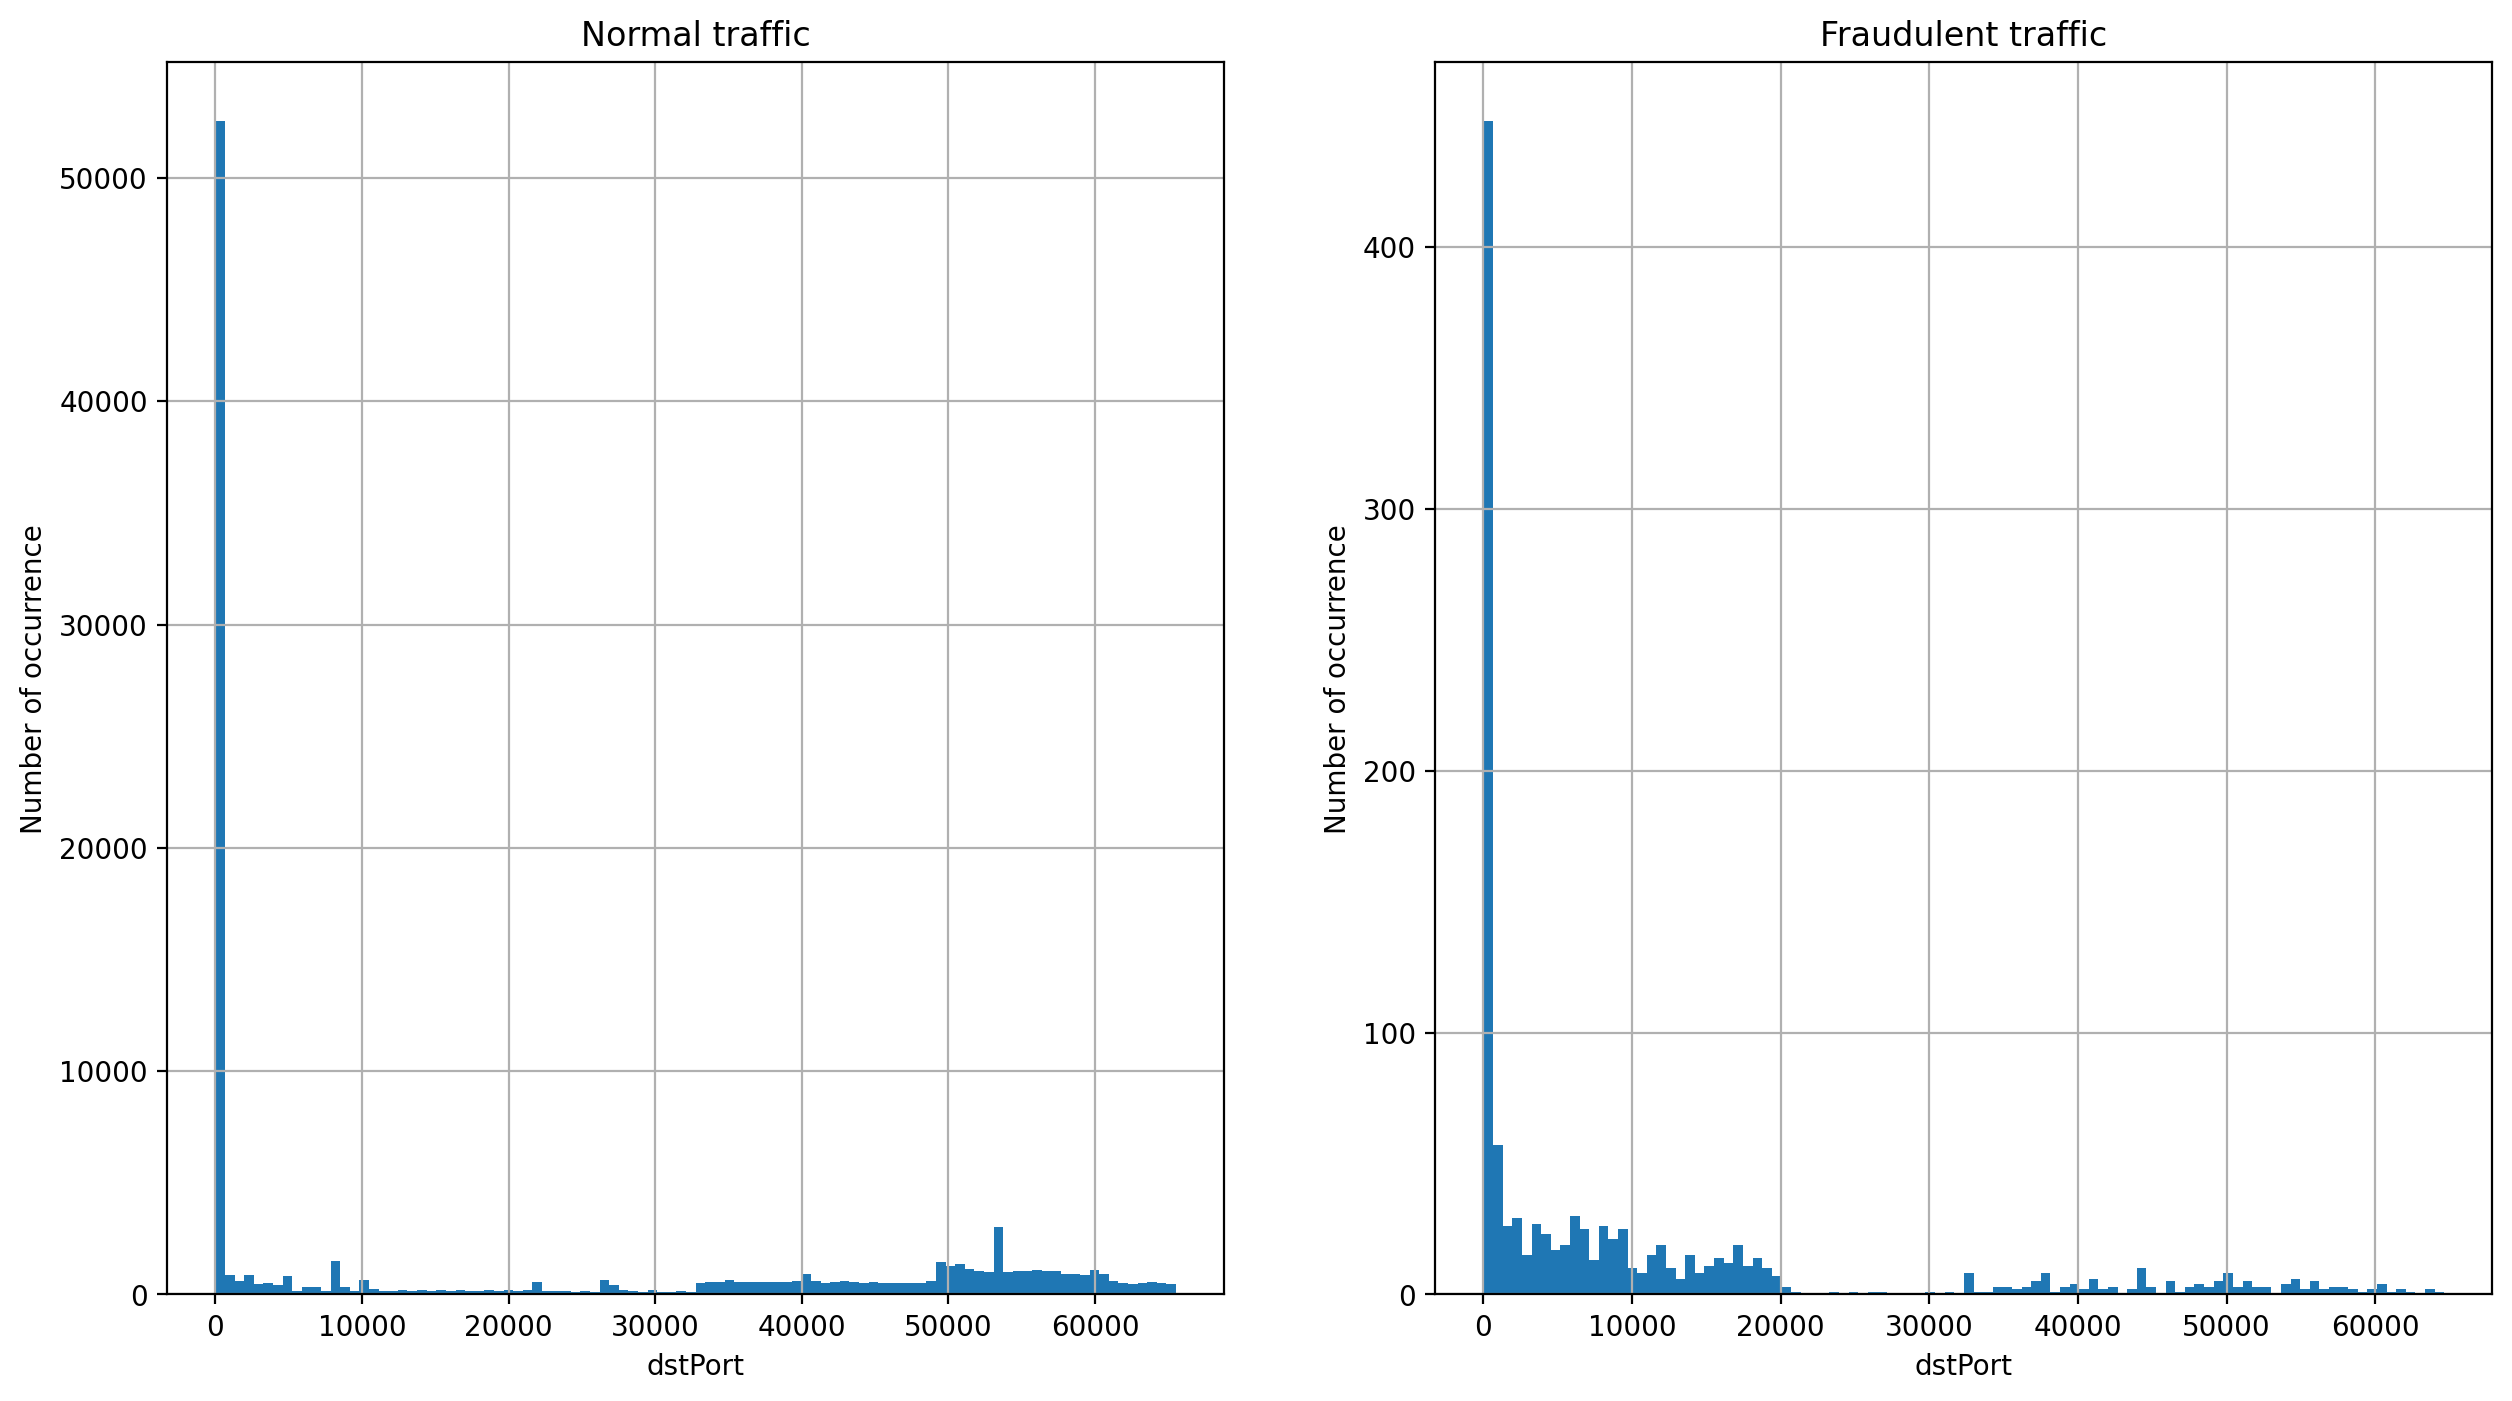

In [28]:
distribution_hist(normal_data, fraud_data, "dstPort", 100)

We can observe that there is almost no fraudulent traffic between destination ports 20000 and 32000. Also the majority of destination ports of fraudulent behaviors are below 20000.

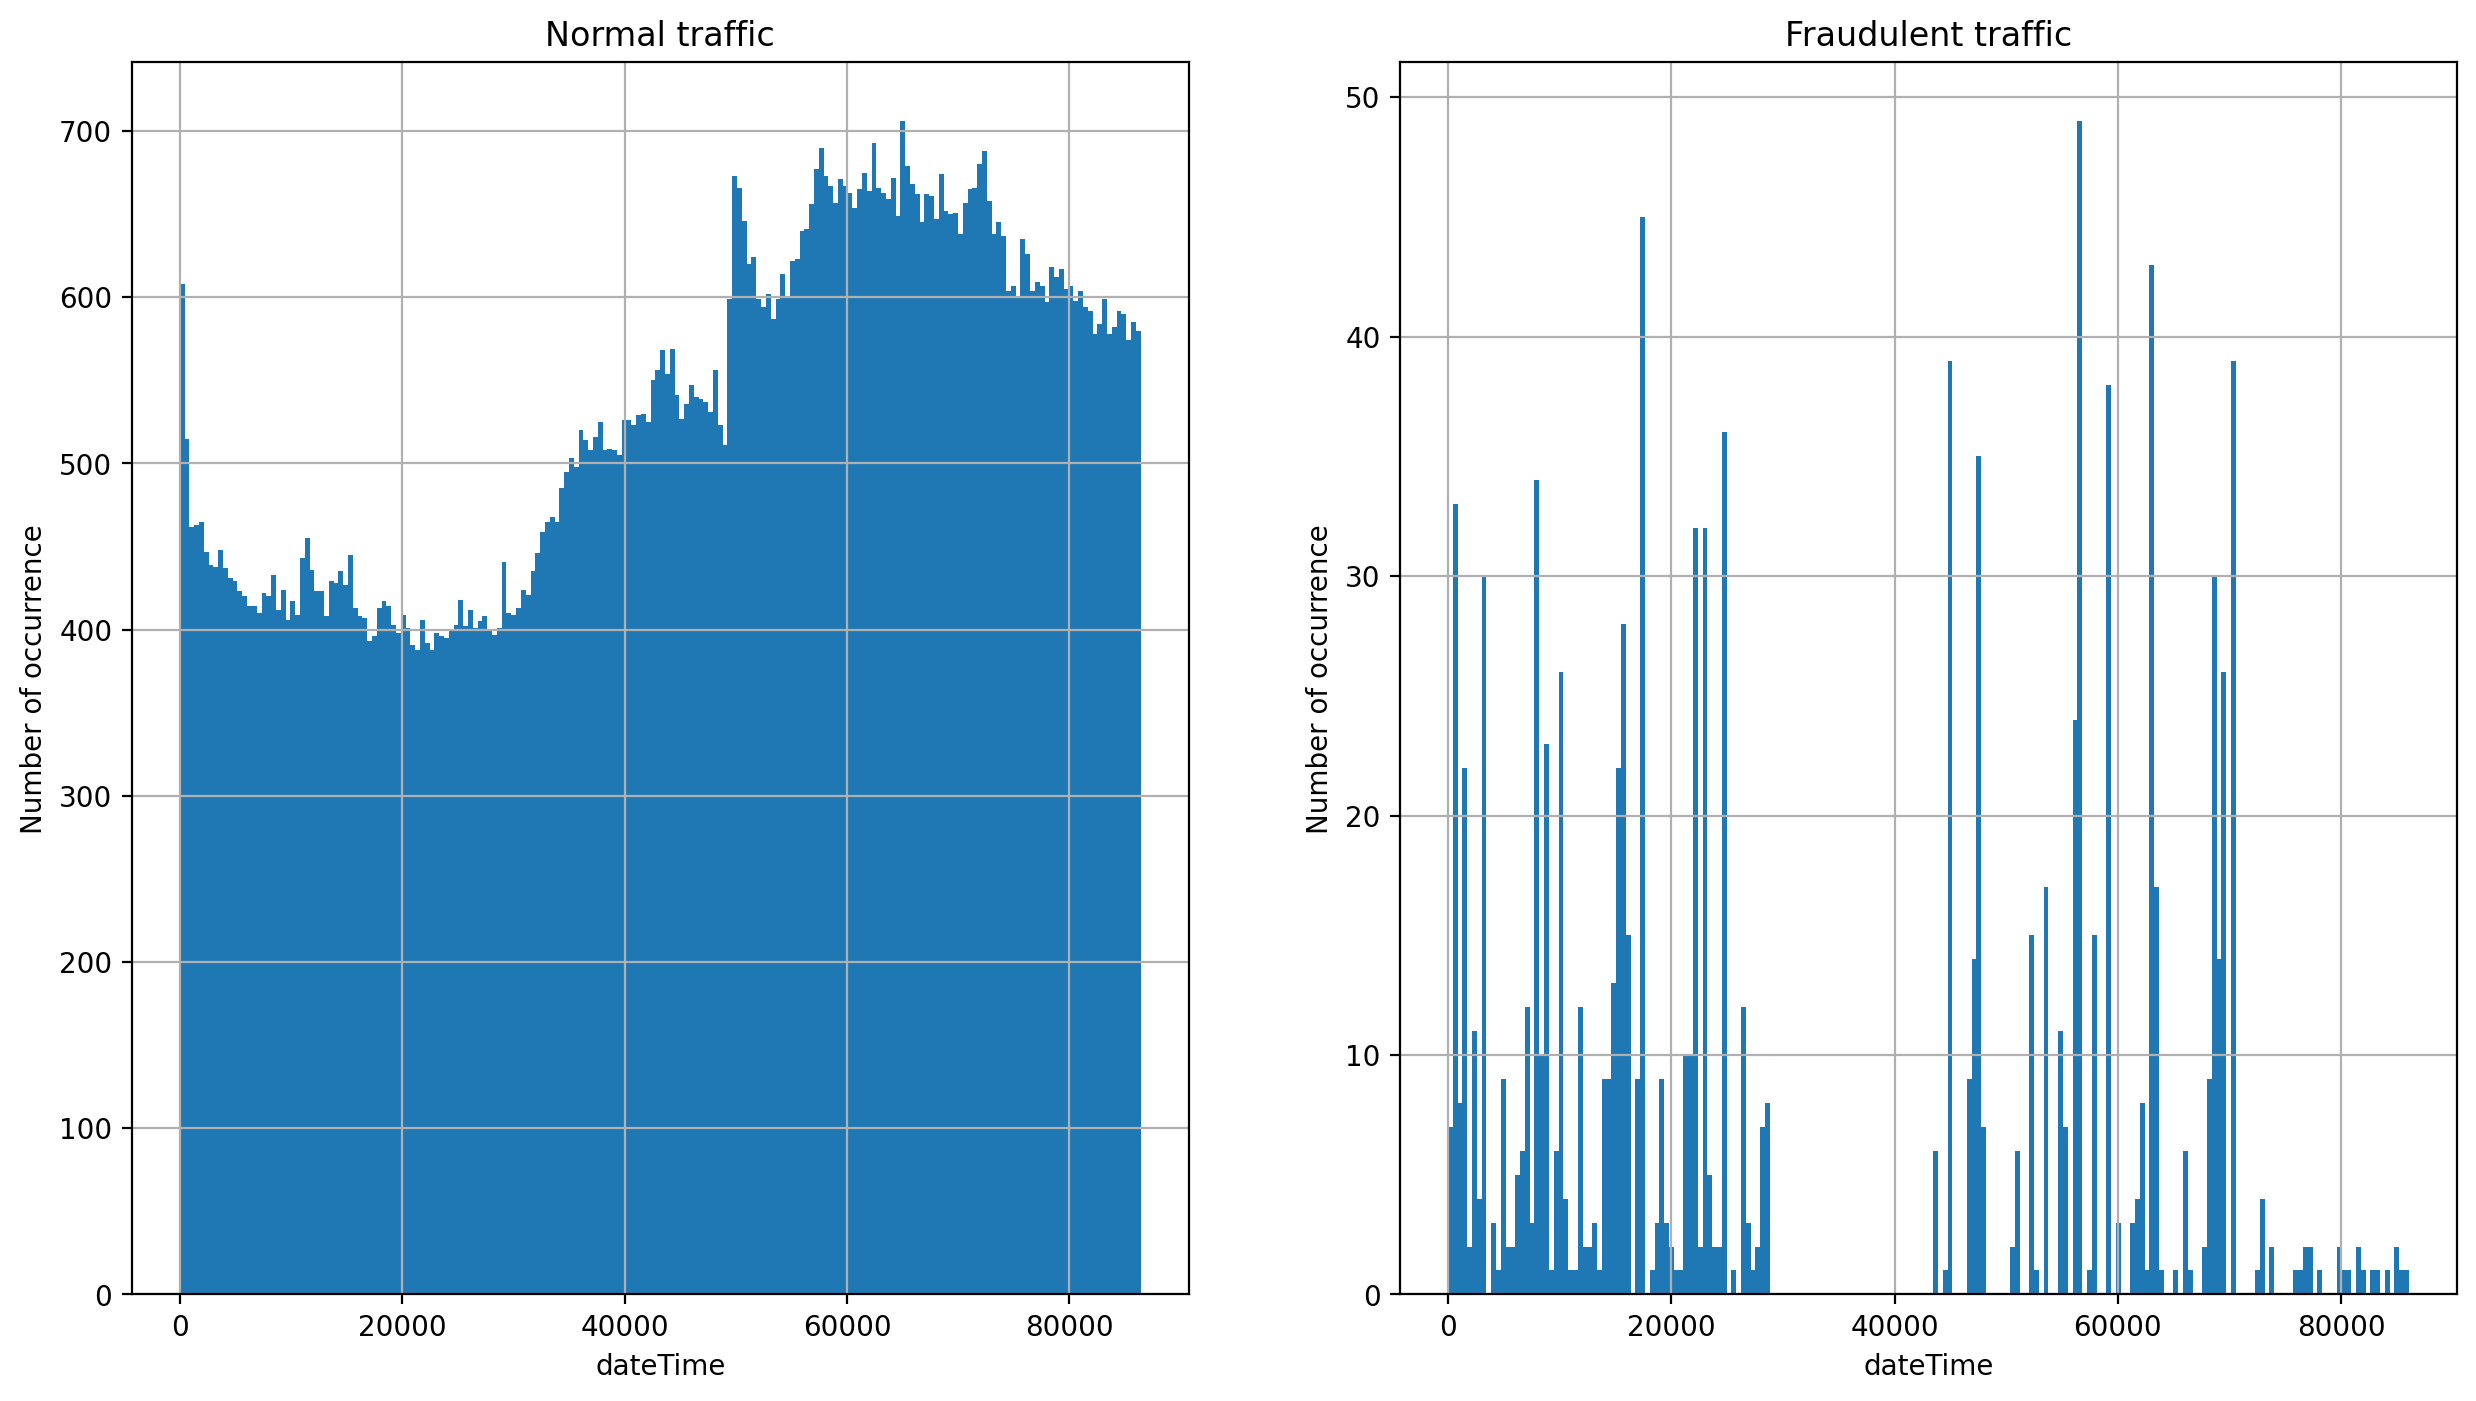

In [29]:
distribution_hist(normal_data, fraud_data, "dateTime", bins=200)

We can see that the time of fraudulent traffic if is very irregular.

## Data visualisation

We are going to see if we can find some information about the dataset's structure by visualising it.

In [30]:
dataset_visu = dataset.copy()

In [31]:
dataset_visu[["flag", "protocol"]] = OrdinalEncoder().fit_transform(dataset_visu[["flag", "protocol"]])

In [32]:
dataset_visu.head()

dateTime  duration  srcPort  dstPort  protocol  flag  tos  packets  bytes  \
0     49415     2.600       80    51414       5.0  15.0    0       56  78899   
1     49421     0.268    65527      443       5.0  13.0    0        8   1328   
2     49427     0.000       53    43621       6.0   4.0    0        1    141   
3     49432     0.556       80     8116       5.0   7.0    0        3    128   
4     49437     6.228    65431       80       5.0   7.0    0        4    172   

   label  
0      0  
1      0  
2      0  
3      0  
4      0

In [33]:
def show3D_plot(data, x_axis_name, y_axis_name, z_axis_name):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    normal = data[data.label == 0]
    attack = data[data.label == 1]
    
    norm_normal = (normal[z_axis_name]-normal[z_axis_name].min())/(normal[z_axis_name].max()-normal[z_axis_name].min())
    norm_attack = (attack[z_axis_name]-attack[z_axis_name].min())/(attack[z_axis_name].max()-attack[z_axis_name].min())
    
    ax.scatter(normal[x_axis_name], normal[y_axis_name], norm_normal,
               color='green', alpha=0.03, marker='.', label="Normal traffic")
    ax.scatter(attack[x_axis_name], attack[y_axis_name], norm_attack,
               color='red', alpha=0.5, marker='.', label="Fraudulent traffic")
    
    ax.set_xlabel(x_axis_name)
    ax.set_ylabel(y_axis_name)
    ax.set_zlabel(z_axis_name)
    ax.legend()

    plt.show()

In [34]:
def show2D_plot(data, x_axis_name, y_axis_name):    
    normal = data[data.label == 0]
    attack = data[data.label == 1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    
    ax1.scatter(normal[x_axis_name], normal[y_axis_name], color='green', alpha=0.03, marker='.')
    ax2.scatter(attack[x_axis_name], attack[y_axis_name], color='red', alpha=0.1, marker='.')
    
    normal_lim = ax1.get_ylim()
    fraud_lim = ax2.get_ylim()
    common_lim = (min(normal_lim[0], fraud_lim[0]), max(normal_lim[1], fraud_lim[1]))
    
    ax1.set_ylim(common_lim)
    ax1.set_xlabel(x_axis_name)
    ax1.set_ylabel(y_axis_name)
    ax1.set_title("Nomal traffic")
    
    ax2.set_title("Fraudulent traffic")
    ax2.set_ylim(common_lim)
    ax2.set_xlabel(x_axis_name)
    ax2.set_ylabel(y_axis_name)
    
    plt.show()

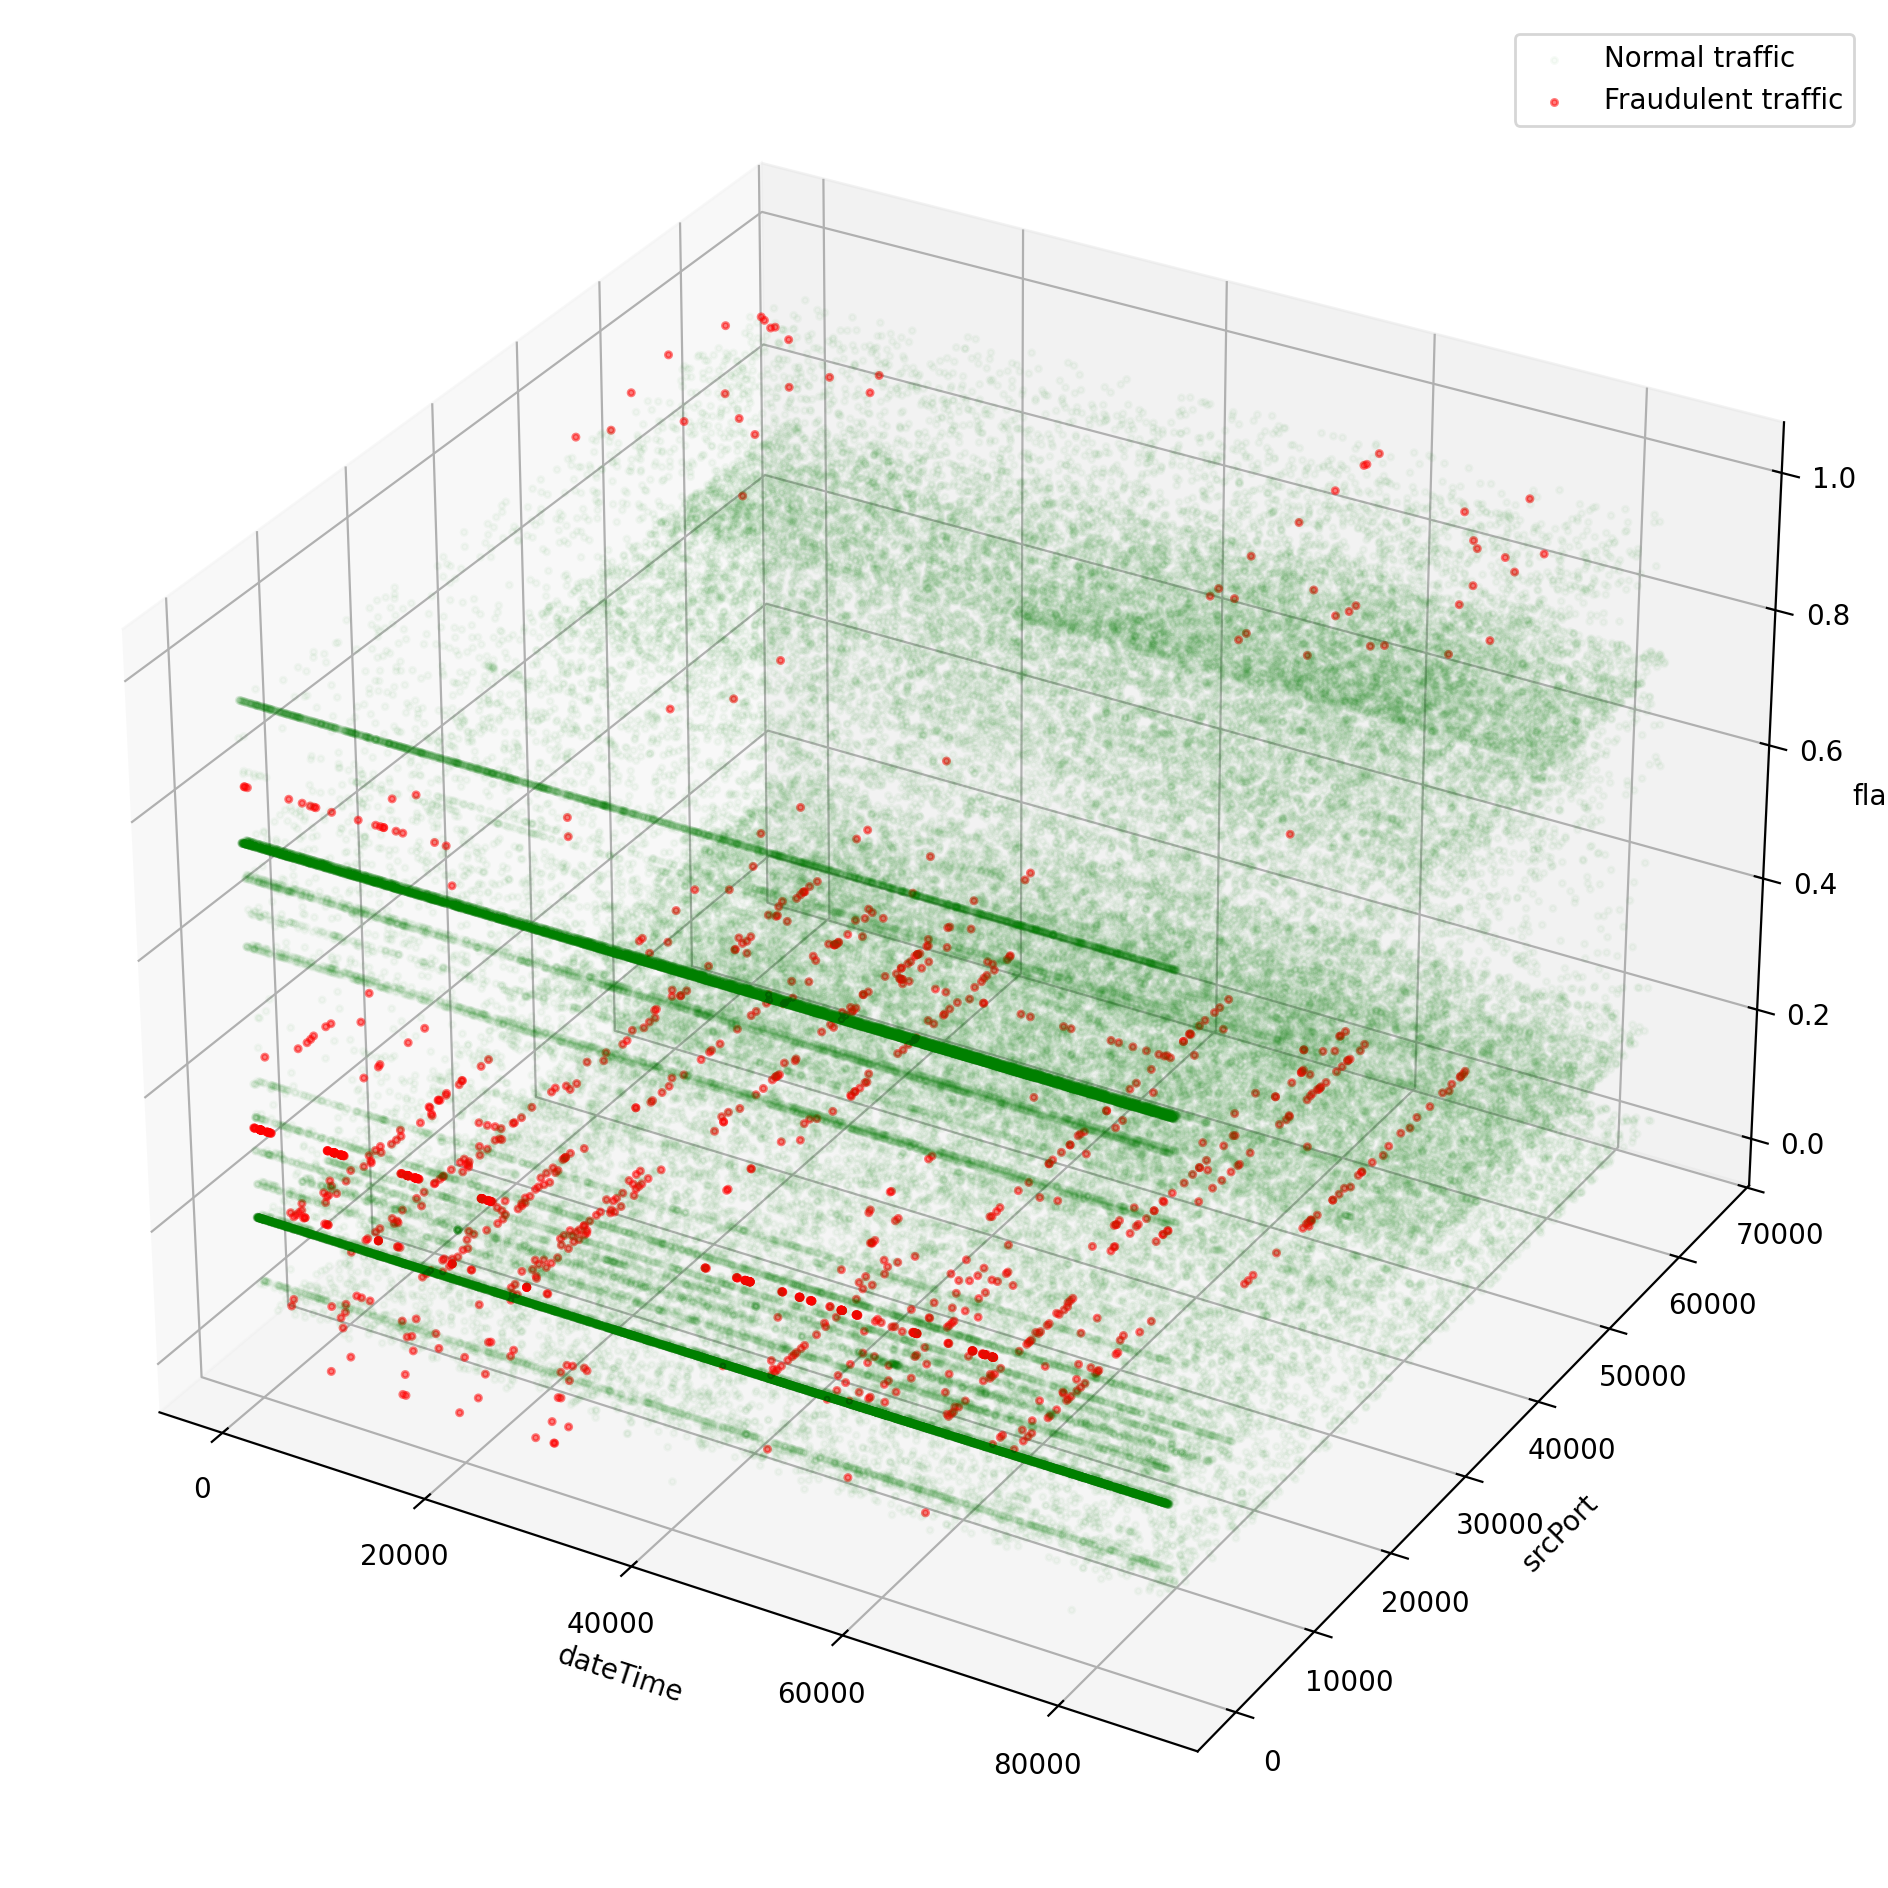

In [35]:
show3D_plot(dataset_visu[:2_000_000], "dateTime", "srcPort", "flag")

We can see a separation between fraudulent traffic and normal traffic

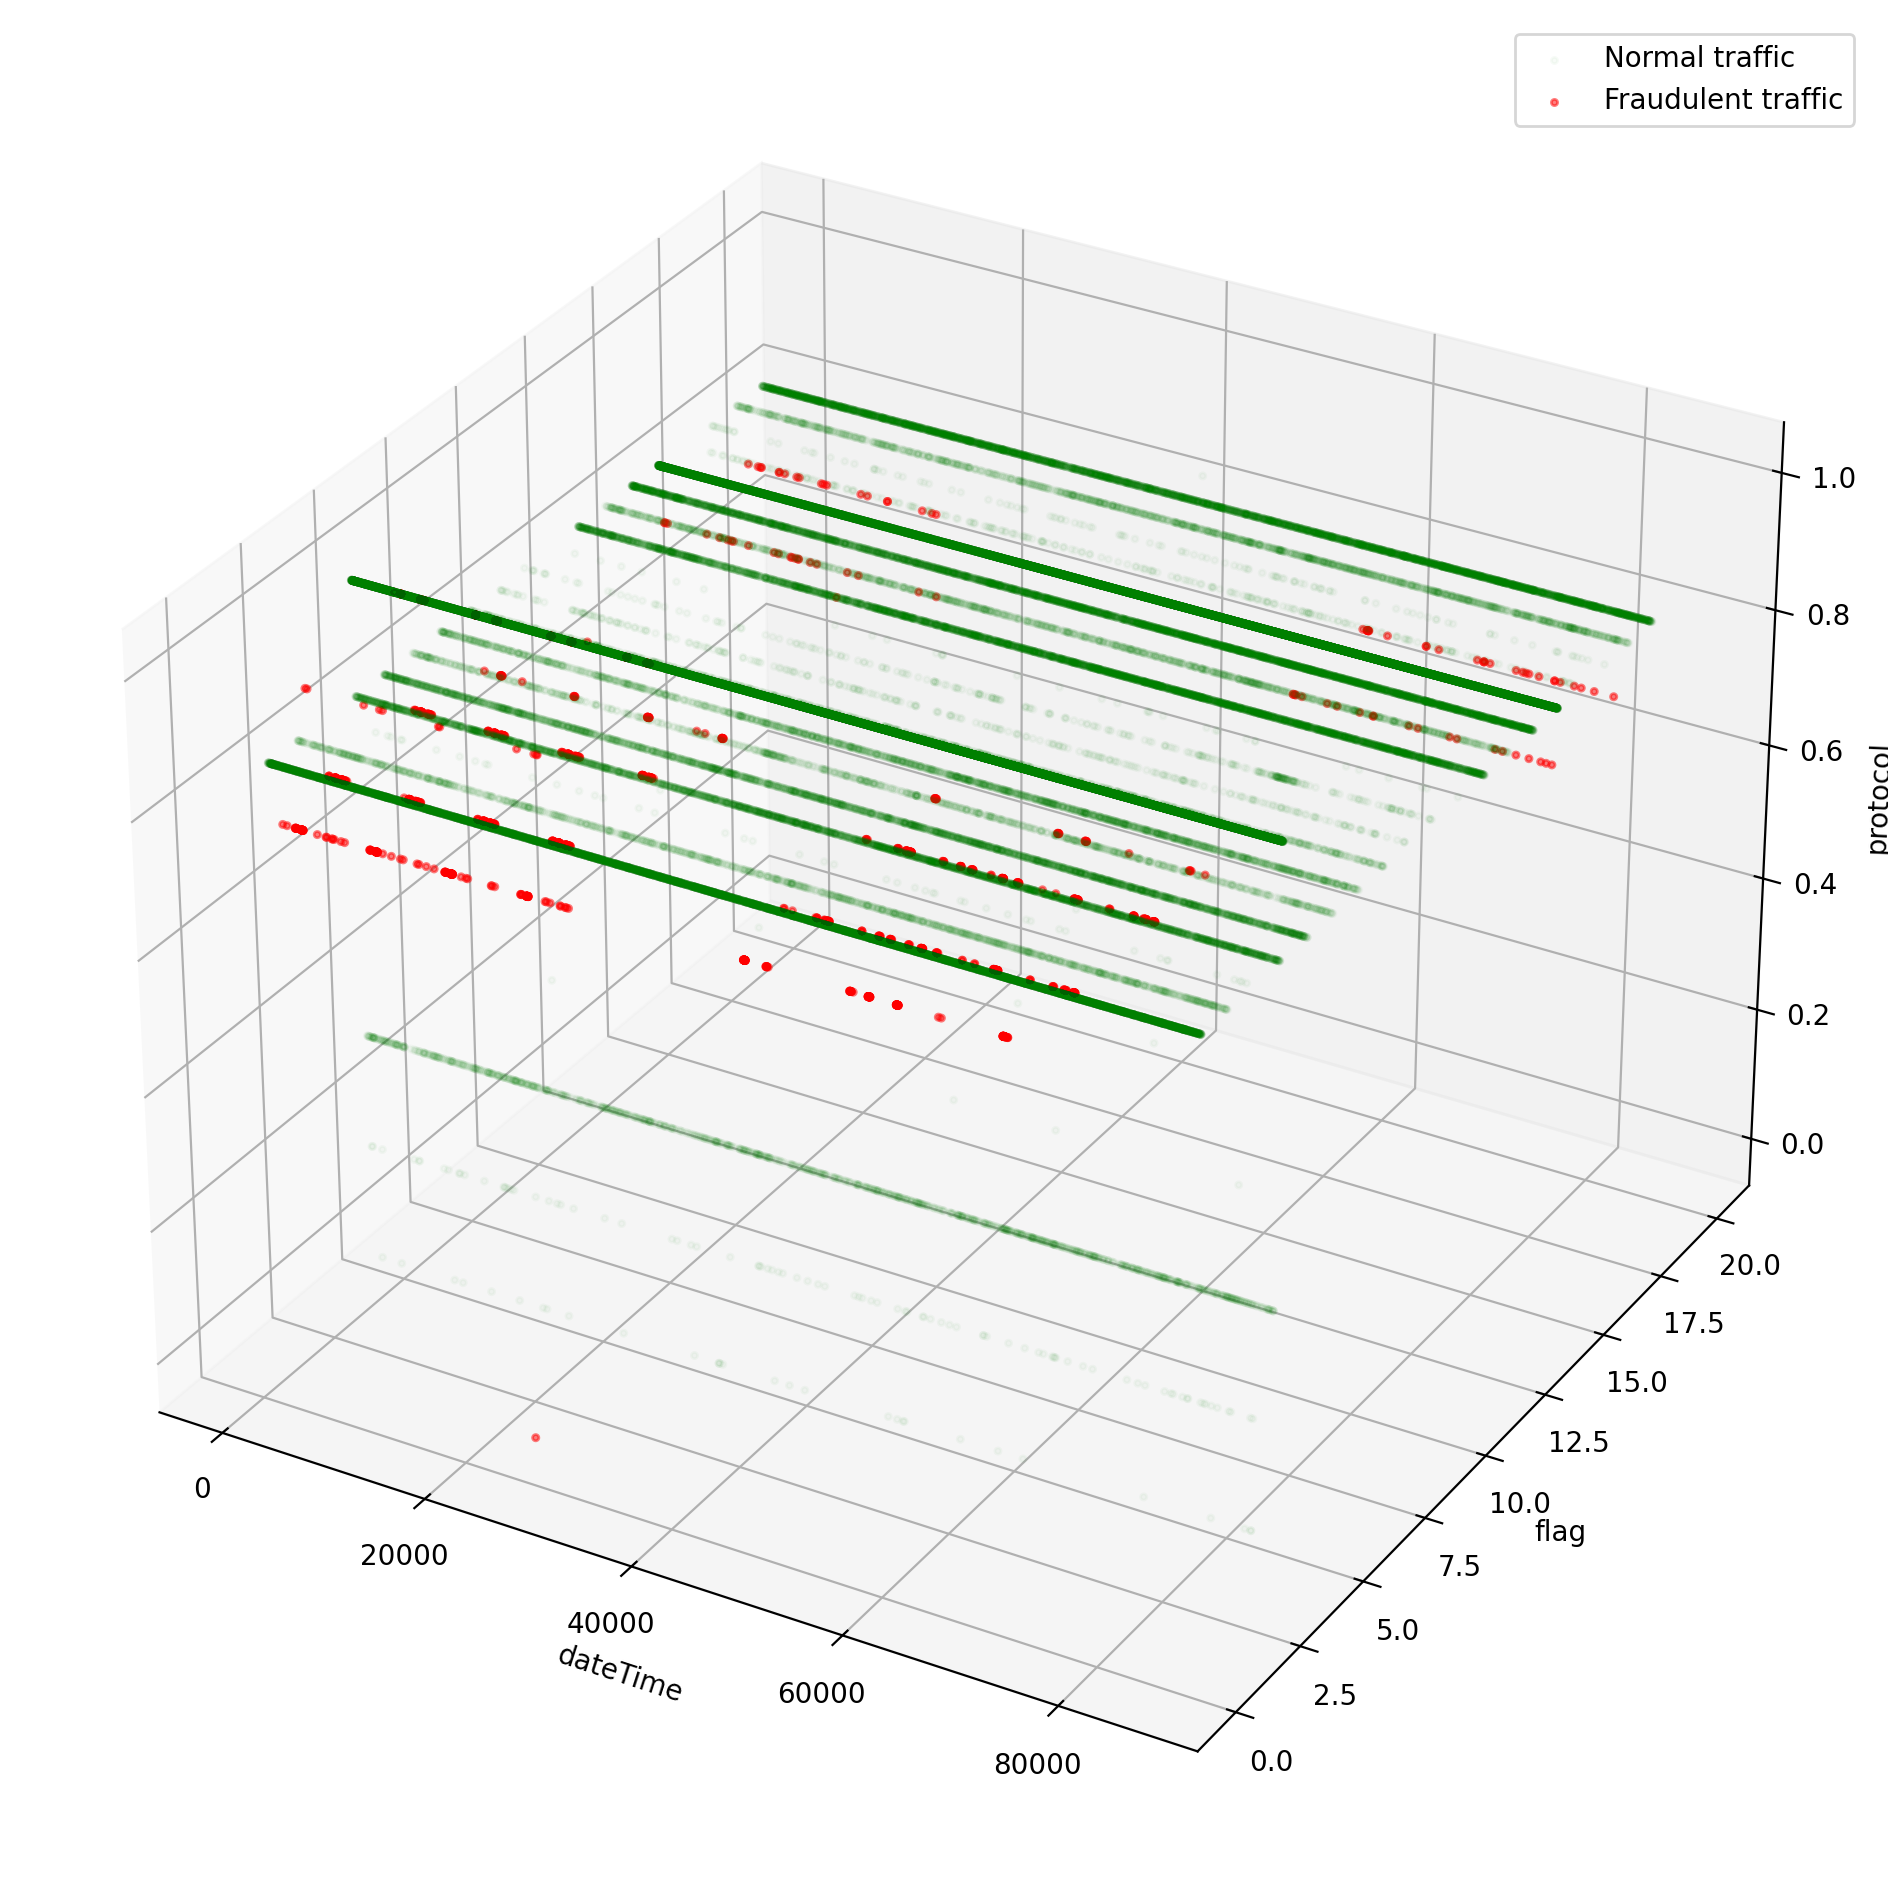

In [36]:
show3D_plot(dataset_visu[:2_000_000], "dateTime", "flag", "protocol")

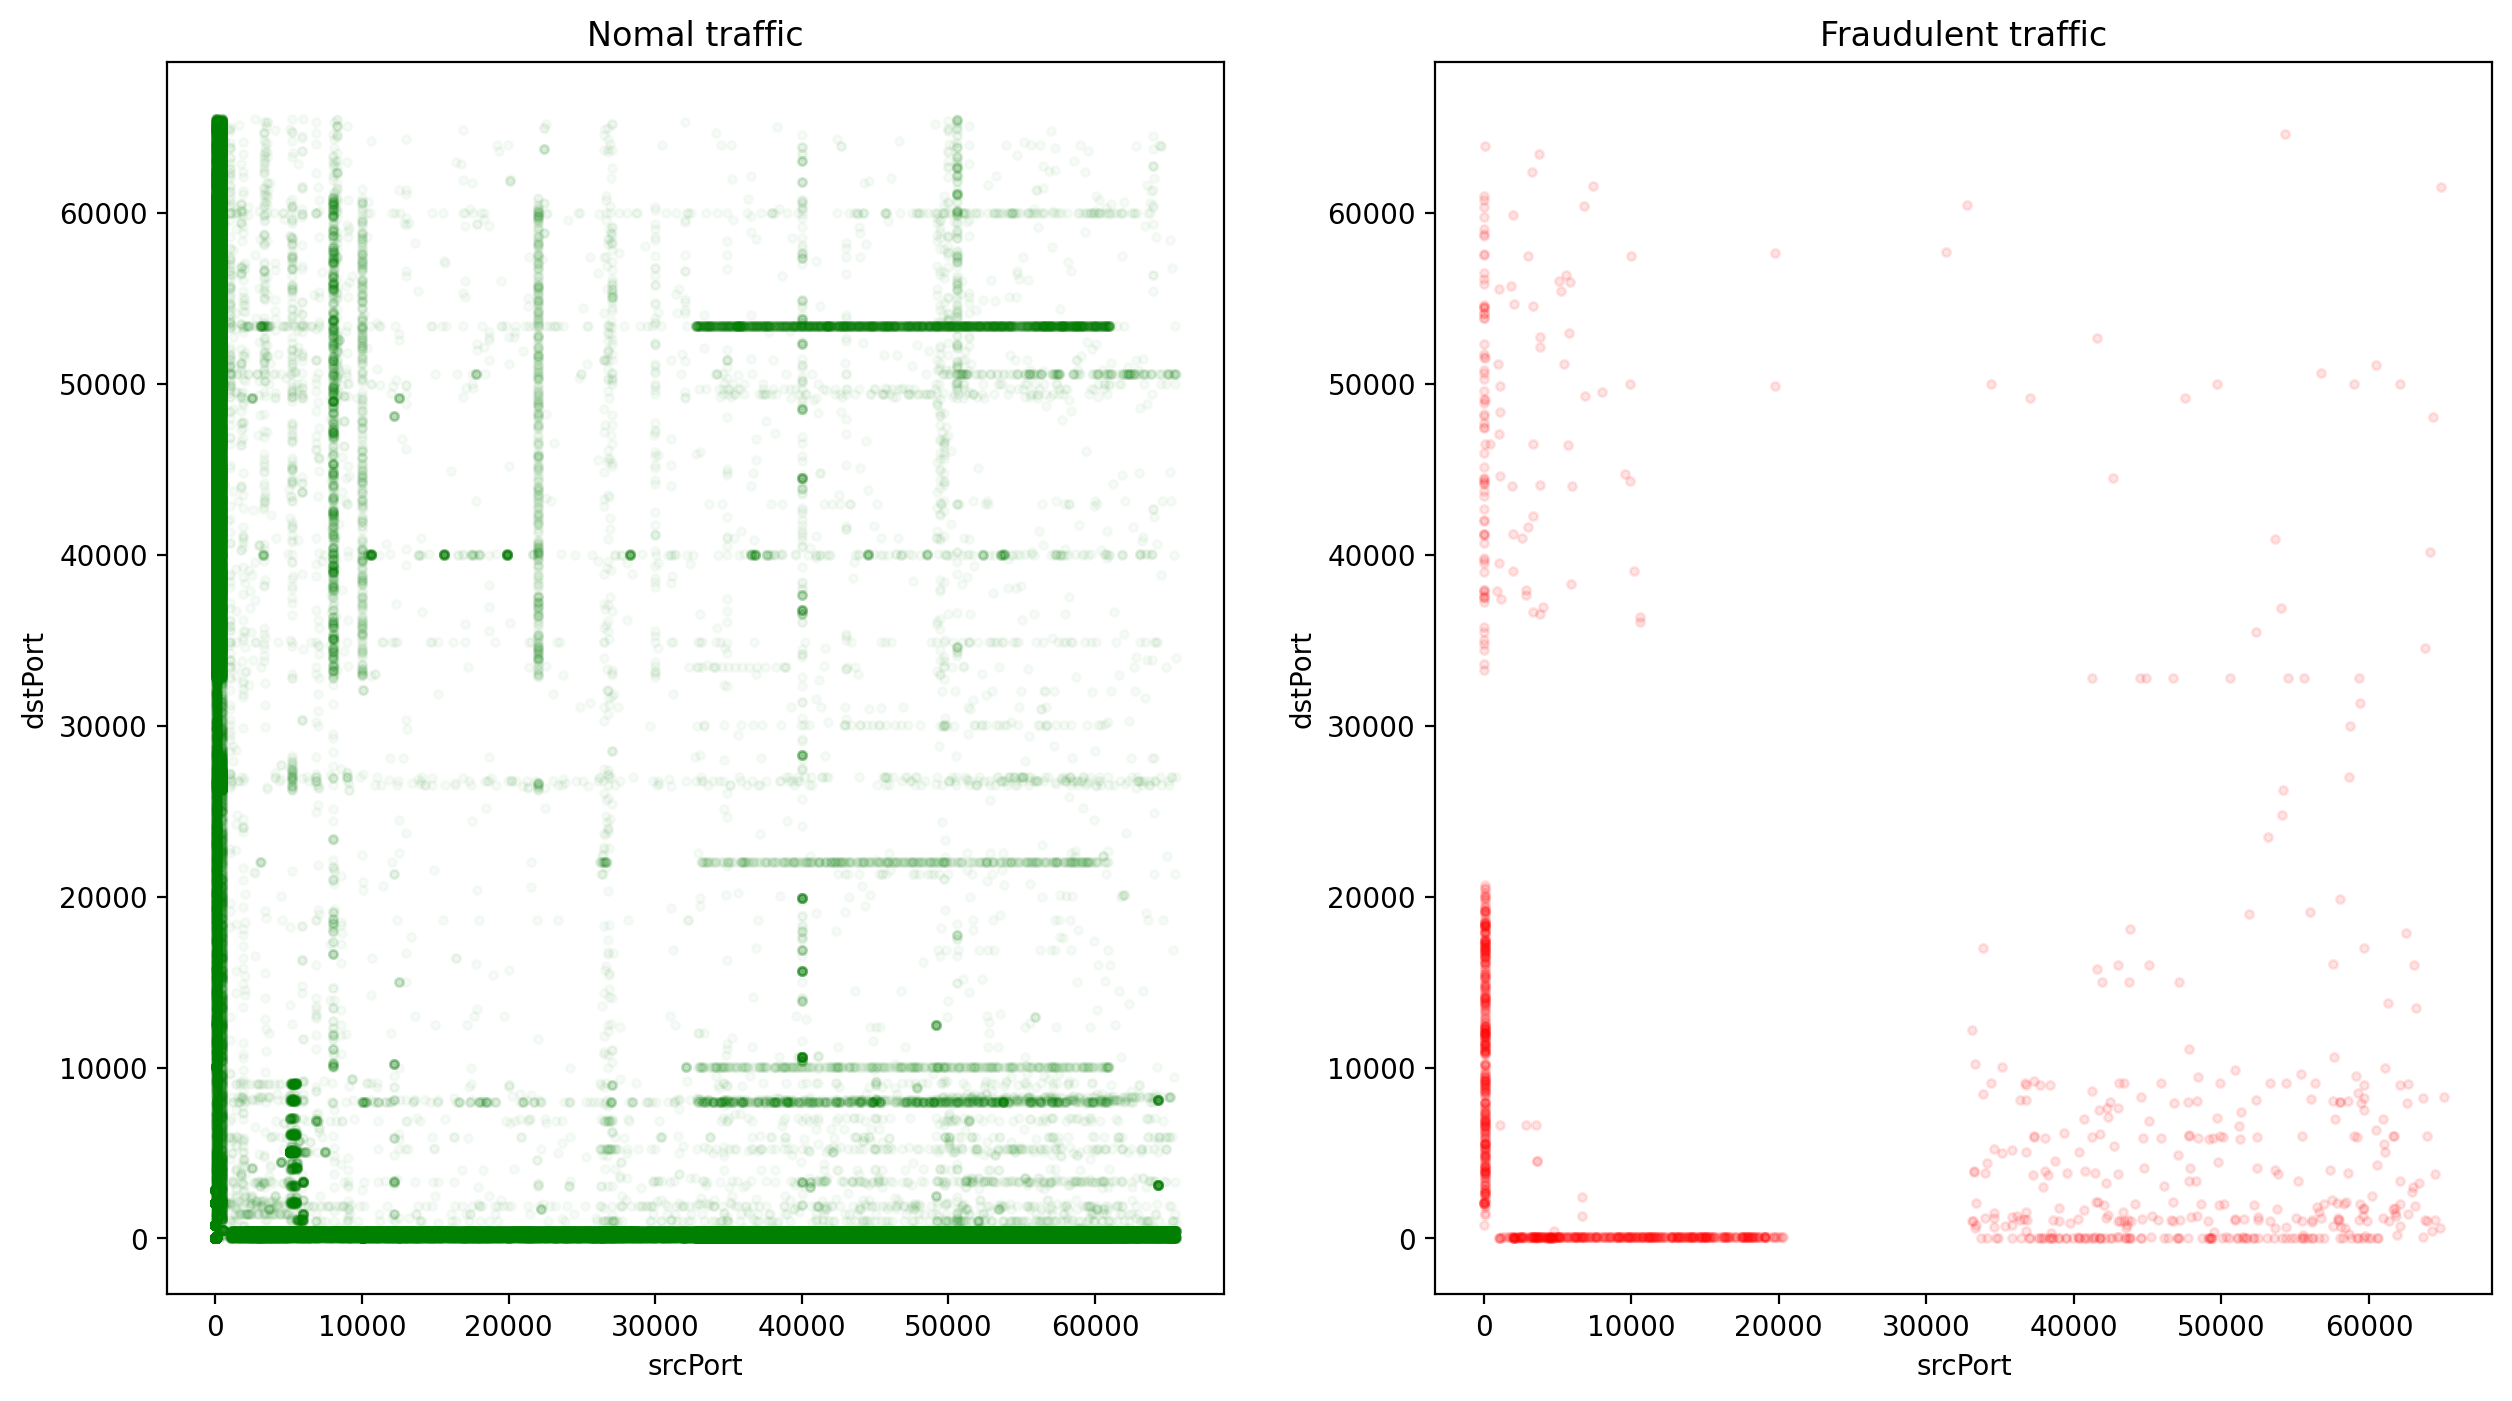

In [37]:
show2D_plot(dataset_visu[:2_000_000], "srcPort", "dstPort")

We can see that the normal traffic uses more combination of srcPort, dstPort.

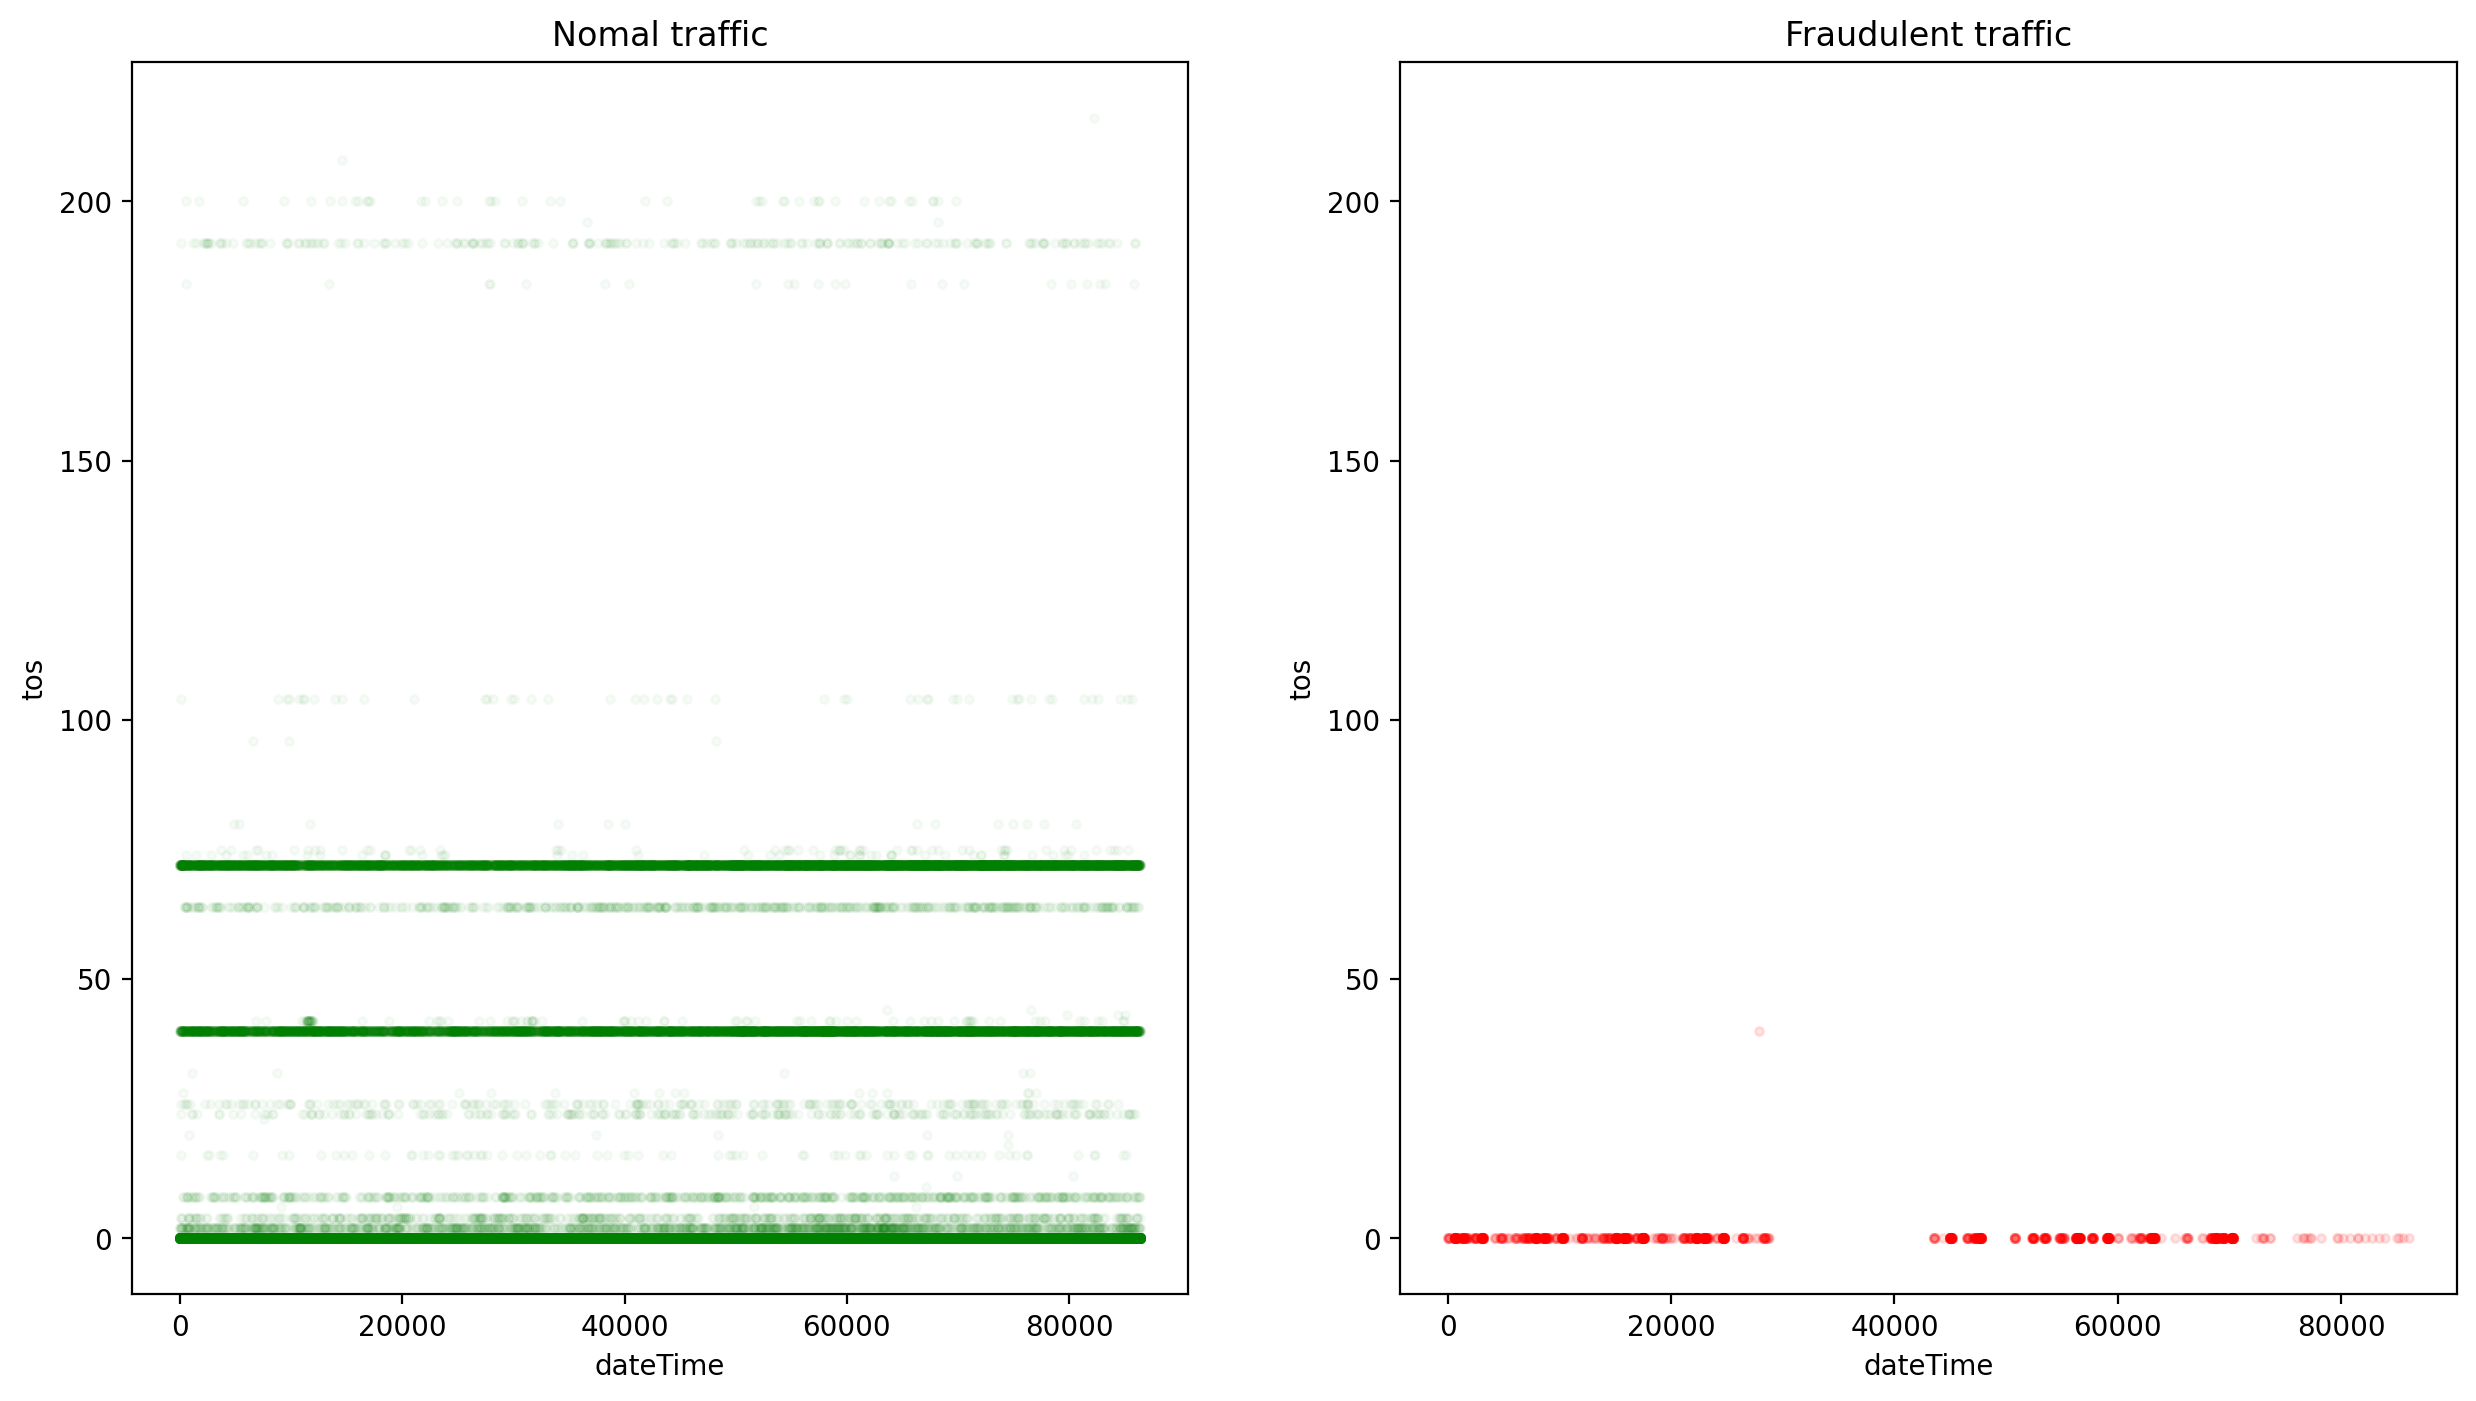

In [38]:
show2D_plot(dataset_visu[:2_000_000], "dateTime", "tos")

In [39]:
def correlation_matrix(dataset):
    corr_fraud = dataset[dataset.label == 1].corr()[:-1]
    corr_normal = dataset[dataset.label == 0].corr()[:-1]
 
    mask = np.triu(np.ones_like(corr_normal, dtype=bool))
    
    grid_kws = {"width_ratios": (.9, .9, .05), "wspace": .2}
    
    fig, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize=(20, 8))
    
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    
    ylabels = list(corr_normal.columns[:-1])
    ylabels[0]=None
    ax1 = sns.heatmap(corr_normal, ax=ax1, vmin=-1, vmax=1, cmap=cmap,
                      square=False, mask=mask, cbar=False, annot=True,
                      xticklabels=corr_normal.columns[:-2], yticklabels=ylabels)
    ax1.set_title("Normal traffic")
    
    ax2 = sns.heatmap(corr_fraud, ax=ax2, vmin=-1, vmax=1, cmap=cmap, annot=True,
                      square=False, mask=mask, yticklabels=False, cbar_ax=cbar_ax,
                      cbar_kws={"orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]},
                      xticklabels=corr_fraud.columns[:-2])
    ax2.set_title("Fraudulent traffic")
    
    cbar_ax.set_yticklabels(cbar_ax.get_yticklabels())
    
    fig.suptitle("Correlation matrix")
    
    plt.show()

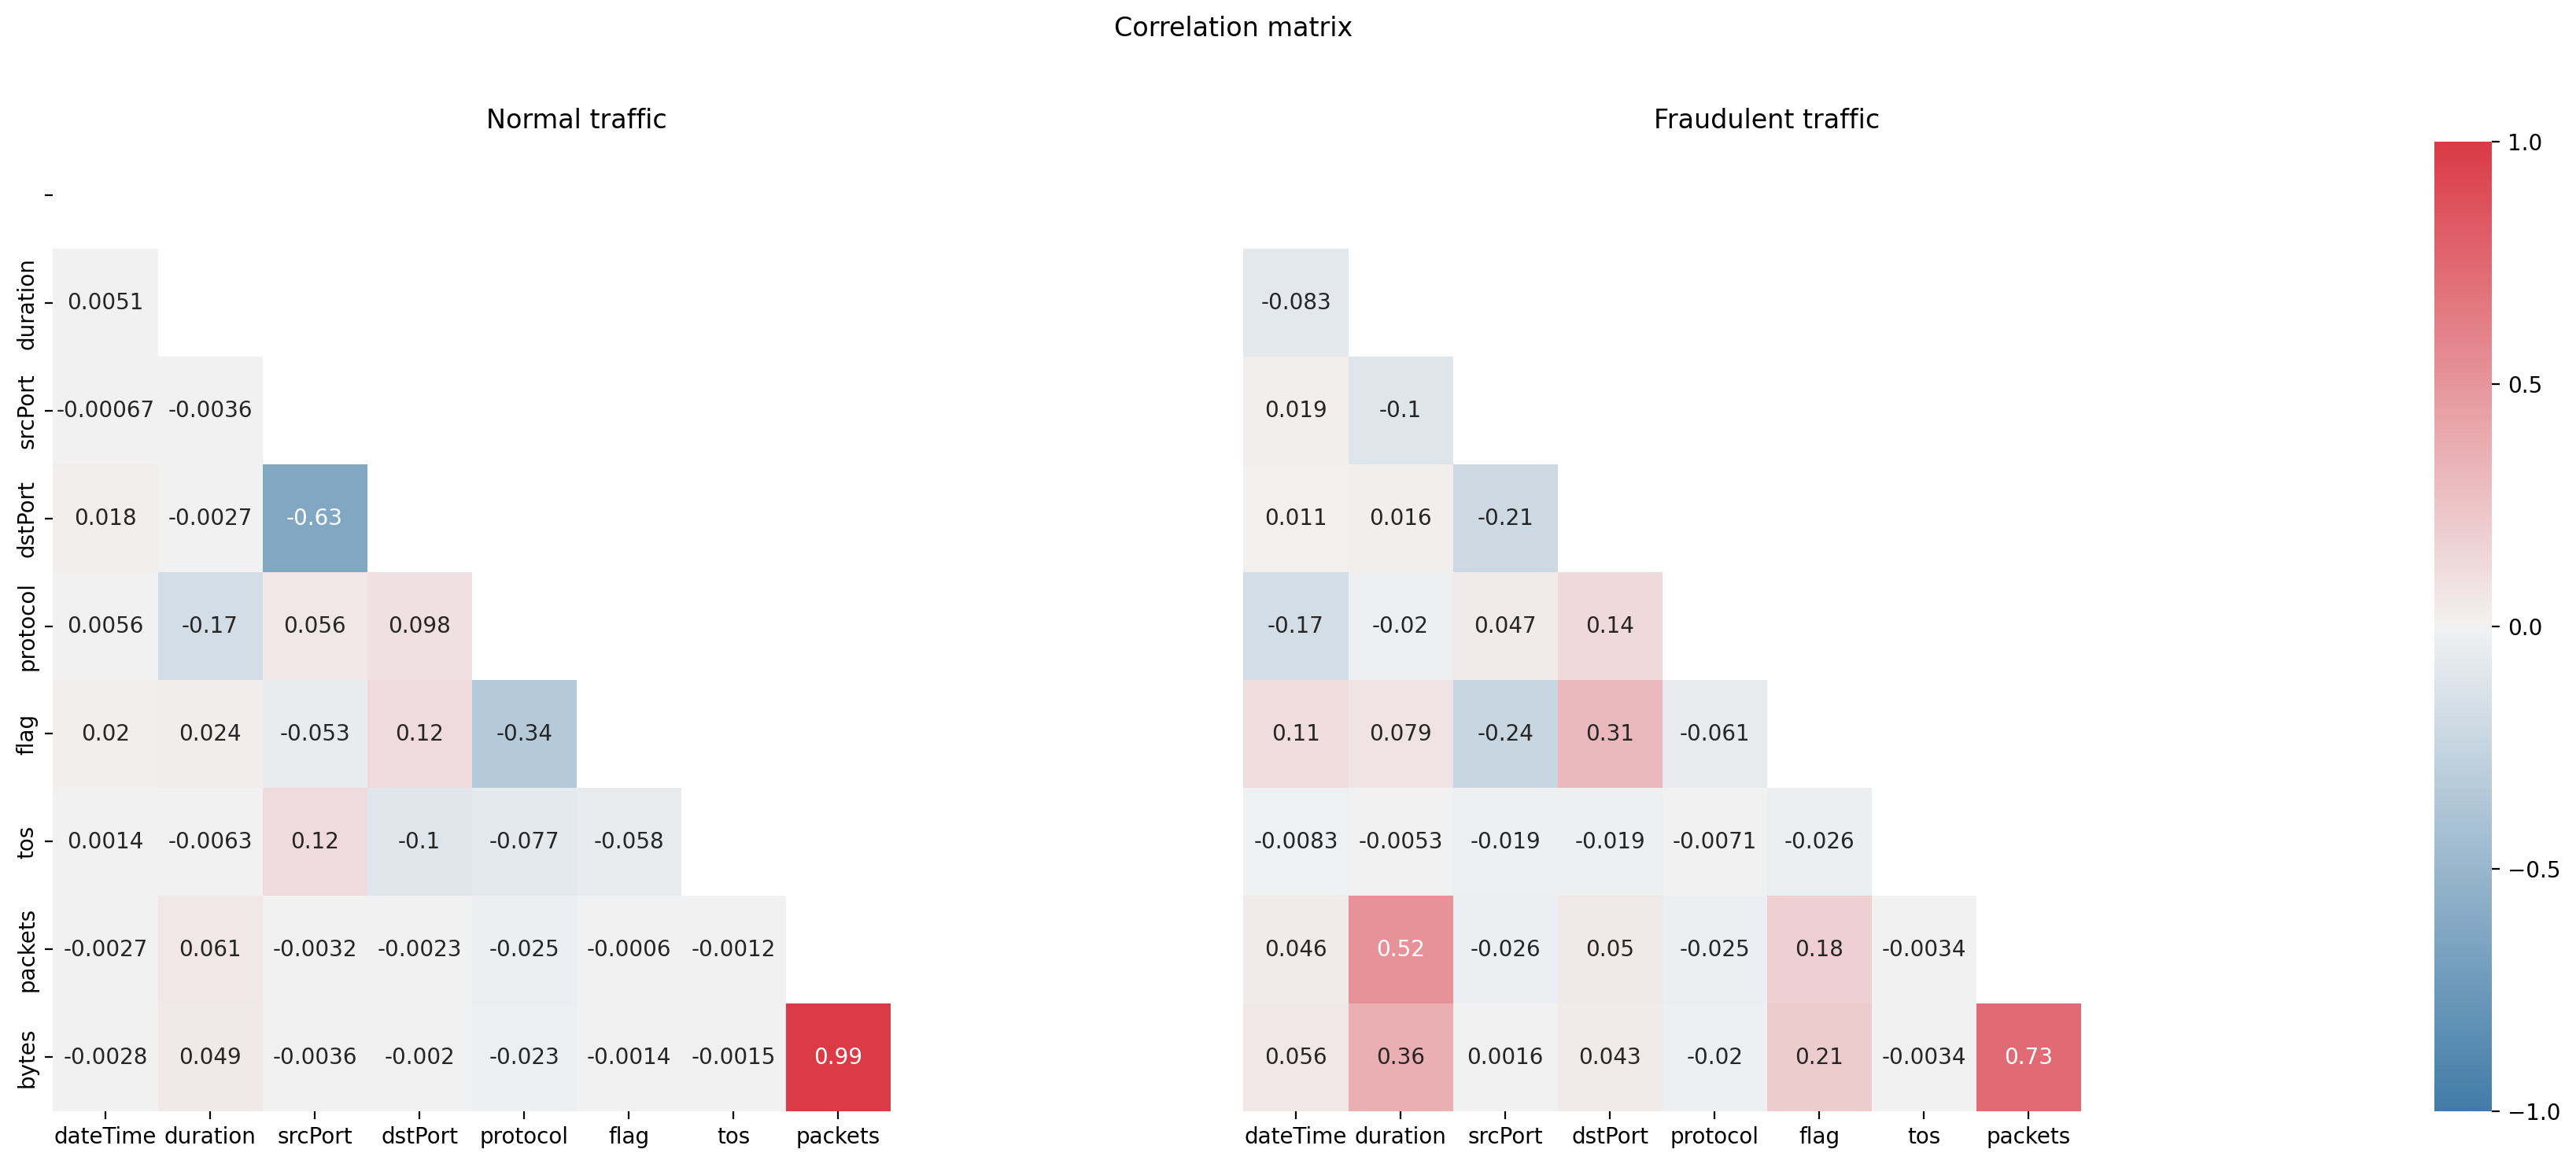

In [40]:
correlation_matrix(dataset_visu)

## Prepare data
We are going to prepare the data before training different ML models.

In this dataset there are two types of data : 
- numerical: *dateTime, duration, packets, bytes and tos*
- categorical: *srcPort, dstPort, protocol and flag*

### Feature engineering 

In [41]:
def create_range_port(val):
    if val <= 500:
        return "a"
    
    if val <= 1000:
        return "b"
    
    if val <= 2000:
        return "c"
    
    if val <= 3000:
        return "e"
    
    if val <= 6500:
        return "f"
    
    if val <= 20_000:
        return "g"
    
    if val <= 32_000:
        return "h"
    
    
    return "i"

In [42]:
X_numerical = dataset[["dateTime", "duration", "packets", "bytes", "tos"]].copy()
X_numcat = dataset[["dstPort", "srcPort"]].copy()
X_categorical = dataset[["protocol", "flag"]].copy()
Y = dataset.label.copy()

### Prepare numerical data

We are going to normalize the numerical data.

In [43]:
X_num_norm = pd.DataFrame(Normalizer().fit_transform(X_numerical), columns=X_numerical.columns)

In [44]:
X_num_norm.head()

dateTime  duration   packets     bytes  tos
0  0.530795  0.000028  0.000602  0.847500  0.0
1  0.999639  0.000005  0.000162  0.026861  0.0
2  0.999996  0.000000  0.000020  0.002853  0.0
3  0.999997  0.000011  0.000061  0.002589  0.0
4  0.999994  0.000126  0.000081  0.003479  0.0

### Prepare categorical data

We are going to encode categorical data

There are many combination of the variables *srcPort, dstPort*, so we will just encode the values without using the one hot encoder.

In [45]:
X_numcat_cat = X_numcat.srcPort.apply(create_range_port).to_frame()
X_numcat_cat['dstPort'] = X_numcat.dstPort.apply(create_range_port)
X_numcat_onehot = pd.get_dummies(X_numcat_cat)

In [46]:
X_numcat_onehot = X_numcat_onehot.astype(int)
X_numcat_onehot.head()

srcPort_a  srcPort_b  srcPort_c  srcPort_e  srcPort_f  srcPort_g  \
0          1          0          0          0          0          0   
1          0          0          0          0          0          0   
2          1          0          0          0          0          0   
3          1          0          0          0          0          0   
4          0          0          0          0          0          0   

   srcPort_h  srcPort_i  dstPort_a  dstPort_b  dstPort_c  dstPort_e  \
0          0          0          0          0          0          0   
1          0          1          1          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          1          1          0          0          0   

   dstPort_f  dstPort_g  dstPort_h  dstPort_i  
0          0          0          0          1  
1          0          0          0          0  
2          0          0          0          1  
3          0          1          0          0  
4          0          0          0          0

For the variables *protocol and flag* we will use a one hot encoding

In [47]:
X_cat_onehot = pd.get_dummies(X_categorical)

In [48]:
X_cat_onehot = X_cat_onehot.astype(int)
X_cat_onehot.head()

protocol_ESP  protocol_GRE  protocol_ICMP  protocol_IPIP  protocol_IPv6  \
0             0             0              0              0              0   
1             0             0              0              0              0   
2             0             0              0              0              0   
3             0             0              0              0              0   
4             0             0              0              0              0   

   protocol_TCP  protocol_UDP  flag_......  flag_....S.  flag_...R..  \
0             1             0            0            0            0   
1             1             0            0            0            0   
2             0             1            0            0            0   
3             1             0            0            0            0   
4             1             0            0            0            0   

   flag_...RS.  flag_.A....  flag_.A...F  flag_.A..S.  flag_.A..SF  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            1            0            0            0   
3            0            0            0            0            1   
4            0            0            0            0            1   

   flag_.A.R..  flag_.A.R.F  flag_.A.RS.  flag_.A.RSF  flag_.AP...  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   flag_.AP..F  flag_.AP.S.  flag_.AP.SF  flag_.APR..  flag_.APR.F  \
0            0            0            1            0            0   
1            1            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   flag_.APRS.  flag_.APRSF  flag_UA..SF  
0            0            0            0  
1            0            0            0  
2            0            0            0  
3            0            0            0  
4            0            0            0

## Machine Learning models

In [49]:
def plot_metrics(y_pred, y_true):
    print("################### Metrics ###################\n")
    
    nb_values = len(y_true)
    nb_attacks = y_true.sum()
    nb_normal = nb_values - nb_attacks
    
    print(f"Number of values: {nb_values}")
    print(f"Number of non fraudulent values: {nb_normal} | {round(nb_normal / nb_values * 100, 5)}% of the data")
    print(f"Number of fraudulent values: {nb_attacks} | {round(nb_attacks / nb_values * 100, 5)}% of the data")
    
    print("")
    
    correct = (y_pred == y_true).sum()
    correct_normal = np.where((y_pred == 0) & (y_true == 0), 1, 0).sum()
    correct_attack = np.where((y_pred == 1) & (y_true == 1), 1, 0).sum()
    false_negative = np.where((y_pred == 1) & (y_true == 0), 1, 0).sum()
    false_positive = np.where((y_pred == 0) & (y_true == 1), 1, 0).sum()
    
    print(f"Number of correct classification: {correct} | Accuracy: {round(correct / nb_values * 100, 5)}%")
    
    print(f"Number of non fraudulent values detected: {correct_normal}\n"
          f"| Percentage of correct classification {round(correct_normal / nb_values * 100, 5)}% (True positive in total number of values)\n"
          f"| Accuracy of the class: {round(correct_normal / nb_normal * 100, 5)}% (True positive in non fraudulent values count)\n")
    
    print(f"Number of fraudulent values detected: {correct_attack}\n"
          f"| Percentage of correct classification {round(correct_attack / nb_values * 100, 5)}% (True negative in total number of values)\n"
          f"| Accuracy of the class: {round(correct_attack / nb_attacks * 100, 5)}% (True negative in fraudulent values count)\n")
    
    print(f"Number of false negative: {false_negative}\n"
          f"| Percentage of false negative: {round(false_negative / nb_values * 100, 5)}% (false negative in total number of values)\n")
    
    print(f"Number of false positive: {false_positive}\n"
          f"| Percentage of false posivive: {round(false_positive / nb_values * 100, 5)}% (false positive in total number of values)")
    
    print("")
    
    print(f"Balanced accuracy score: {round(balanced_accuracy_score(y_true, y_pred) * 100, 5)}%")
    print(f"Precision: {round(precision_score(y_true, y_pred), 5)}")
    print(f"Recall: {round(recall_score(y_true, y_pred), 5)}")
    print(f"R2: {round(r2_score(y_true, y_pred), 5)}")
    print(f"F1 score: {round(f1_score(y_true, y_pred), 5)}")
    
    print("###############################################")

In [50]:
def create_aucroc(classifier, X_test, Y_test):
    Y_test = Y_test.replace(1, -1).replace(0, 1)
    y_pred_iso = classifier.decision_function(X_test)
    fpr, tpr, threshold = roc_curve(Y_test, y_pred_iso)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(12, 8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Isolation Forest

In [51]:
X_feature_if = pd.concat([X_num_norm, X_cat_onehot, X_numcat_onehot], axis=1)
X_train_if, X_test_if, Y_train_if, Y_test_if = train_test_split(X_feature_if, Y, test_size=0.2, random_state=3)

In [52]:
%%time
model_if = IsolationForest(random_state=3, contamination=0.02, n_jobs=6)
model_if = model_if.fit(X_train_if[:300_000])

CPU times: total: 1.28 s
Wall time: 3.25 s


In [53]:
y_pred_if_train = np.where(model_if.predict(X_train_if[:300_000]) == -1, 1, 0)
plot_metrics(y_pred_if_train, Y_train_if[:300_000])

################### Metrics ###################

Number of values: 86092
Number of non fraudulent values: 85145 | 98.90001% of the data
Number of fraudulent values: 947 | 1.09999% of the data

Number of correct classification: 83438 | Accuracy: 96.91725%
Number of non fraudulent values detected: 83431
| Percentage of correct classification 96.90912% (True positive in total number of values)
| Accuracy of the class: 97.98696% (True positive in non fraudulent values count)

Number of fraudulent values detected: 7
| Percentage of correct classification 0.00813% (True negative in total number of values)
| Accuracy of the class: 0.73918% (True negative in fraudulent values count)

Number of false negative: 1714
| Percentage of false negative: 1.99089% (false negative in total number of values)

Number of false positive: 940
| Percentage of false posivive: 1.09186% (false positive in total number of values)

Balanced accuracy score: 49.36307%
Precision: 0.00407
Recall: 0.00739
R2: -1.8337
F1

In [54]:
y_pred_if_test = np.where(model_if.predict(X_test_if[:200_000]) == -1, 1, 0)
plot_metrics(y_pred_if_test, Y_test_if[:200_000])

################### Metrics ###################

Number of values: 21523
Number of non fraudulent values: 21316 | 99.03824% of the data
Number of fraudulent values: 207 | 0.96176% of the data

Number of correct classification: 20869 | Accuracy: 96.96139%
Number of non fraudulent values detected: 20868
| Percentage of correct classification 96.95674% (True positive in total number of values)
| Accuracy of the class: 97.89829% (True positive in non fraudulent values count)

Number of fraudulent values detected: 1
| Percentage of correct classification 0.00465% (True negative in total number of values)
| Accuracy of the class: 0.48309% (True negative in fraudulent values count)

Number of false negative: 448
| Percentage of false negative: 2.08149% (false negative in total number of values)

Number of false positive: 206
| Percentage of false posivive: 0.95712% (false positive in total number of values)

Balanced accuracy score: 49.19069%
Precision: 0.00223
Recall: 0.00483
R2: -2.1901
F1 

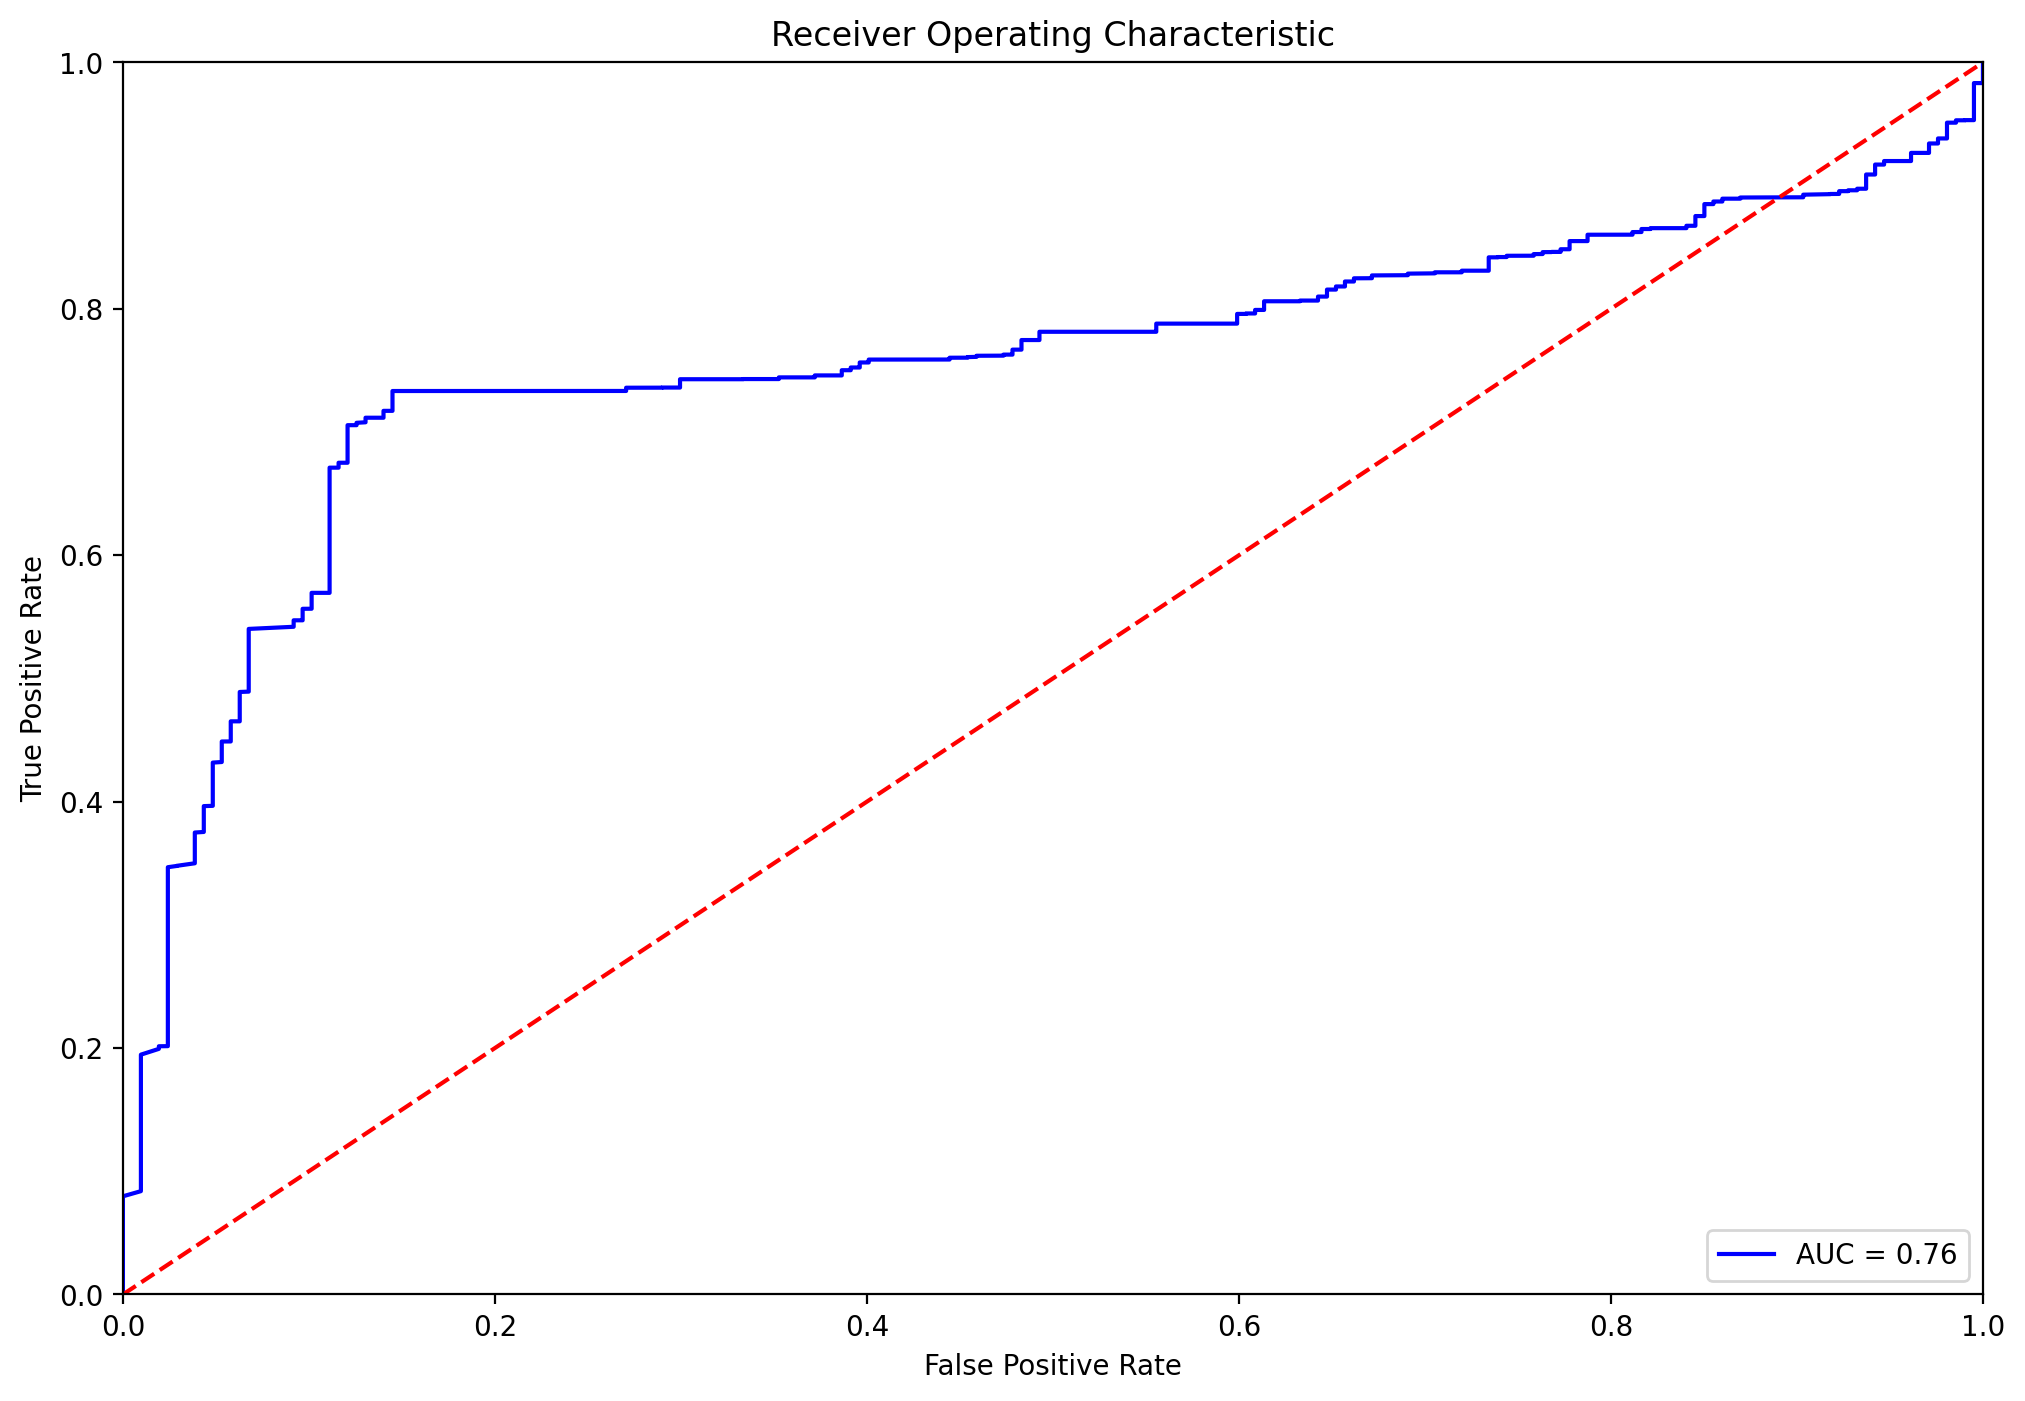

In [55]:
create_aucroc(model_if, X_test_if[:200_000], Y_test_if[:200_000])

We can see with this model that we cannot classify correctly the fraudulent traffic.

### One class SVM

In [56]:
X_feature_svm = pd.concat([X_num_norm, X_cat_onehot, X_numcat_onehot], axis=1)
X_train_svm, X_test_svm, Y_train_svm, Y_test_svm = train_test_split(X_feature_svm, Y, test_size=0.2, random_state=3)

In [57]:

%%time
model_svm = OneClassSVM(kernel="linear")
model_svm = model_svm.fit(X_train_svm[:20_000])

CPU times: total: 12.5 s
Wall time: 38.2 s


In [58]:
y_pred_svm_train = np.where(model_svm.predict(X_train_svm[:20_000]) == -1, 1, 0)
plot_metrics(y_pred_svm_train, Y_train_svm[:20_000])

################### Metrics ###################

Number of values: 20000
Number of non fraudulent values: 19769 | 98.845% of the data
Number of fraudulent values: 231 | 1.155% of the data

Number of correct classification: 10181 | Accuracy: 50.905%
Number of non fraudulent values detected: 9976
| Percentage of correct classification 49.88% (True positive in total number of values)
| Accuracy of the class: 50.46285% (True positive in non fraudulent values count)

Number of fraudulent values detected: 205
| Percentage of correct classification 1.025% (True negative in total number of values)
| Accuracy of the class: 88.74459% (True negative in fraudulent values count)

Number of false negative: 9793
| Percentage of false negative: 48.965% (false negative in total number of values)

Number of false positive: 26
| Percentage of false posivive: 0.13% (false positive in total number of values)

Balanced accuracy score: 69.60372%
Precision: 0.0205
Recall: 0.88745
R2: -42.00318
F1 score: 0.040

In [59]:
y_pred_svm_test = np.where(model_svm.predict(X_test_svm[:15_000]) == -1, 1, 0)
plot_metrics(y_pred_svm_test, Y_test_svm[:15_000])

################### Metrics ###################

Number of values: 15000
Number of non fraudulent values: 14859 | 99.06% of the data
Number of fraudulent values: 141 | 0.94% of the data

Number of correct classification: 7603 | Accuracy: 50.68667%
Number of non fraudulent values detected: 7471
| Percentage of correct classification 49.80667% (True positive in total number of values)
| Accuracy of the class: 50.27929% (True positive in non fraudulent values count)

Number of fraudulent values detected: 132
| Percentage of correct classification 0.88% (True negative in total number of values)
| Accuracy of the class: 93.61702% (True negative in fraudulent values count)

Number of false negative: 7388
| Percentage of false negative: 49.25333% (false negative in total number of values)

Number of false positive: 9
| Percentage of false posivive: 0.06% (false positive in total number of values)

Balanced accuracy score: 71.94816%
Precision: 0.01755
Recall: 0.93617
R2: -51.95881
F1 score: 0.

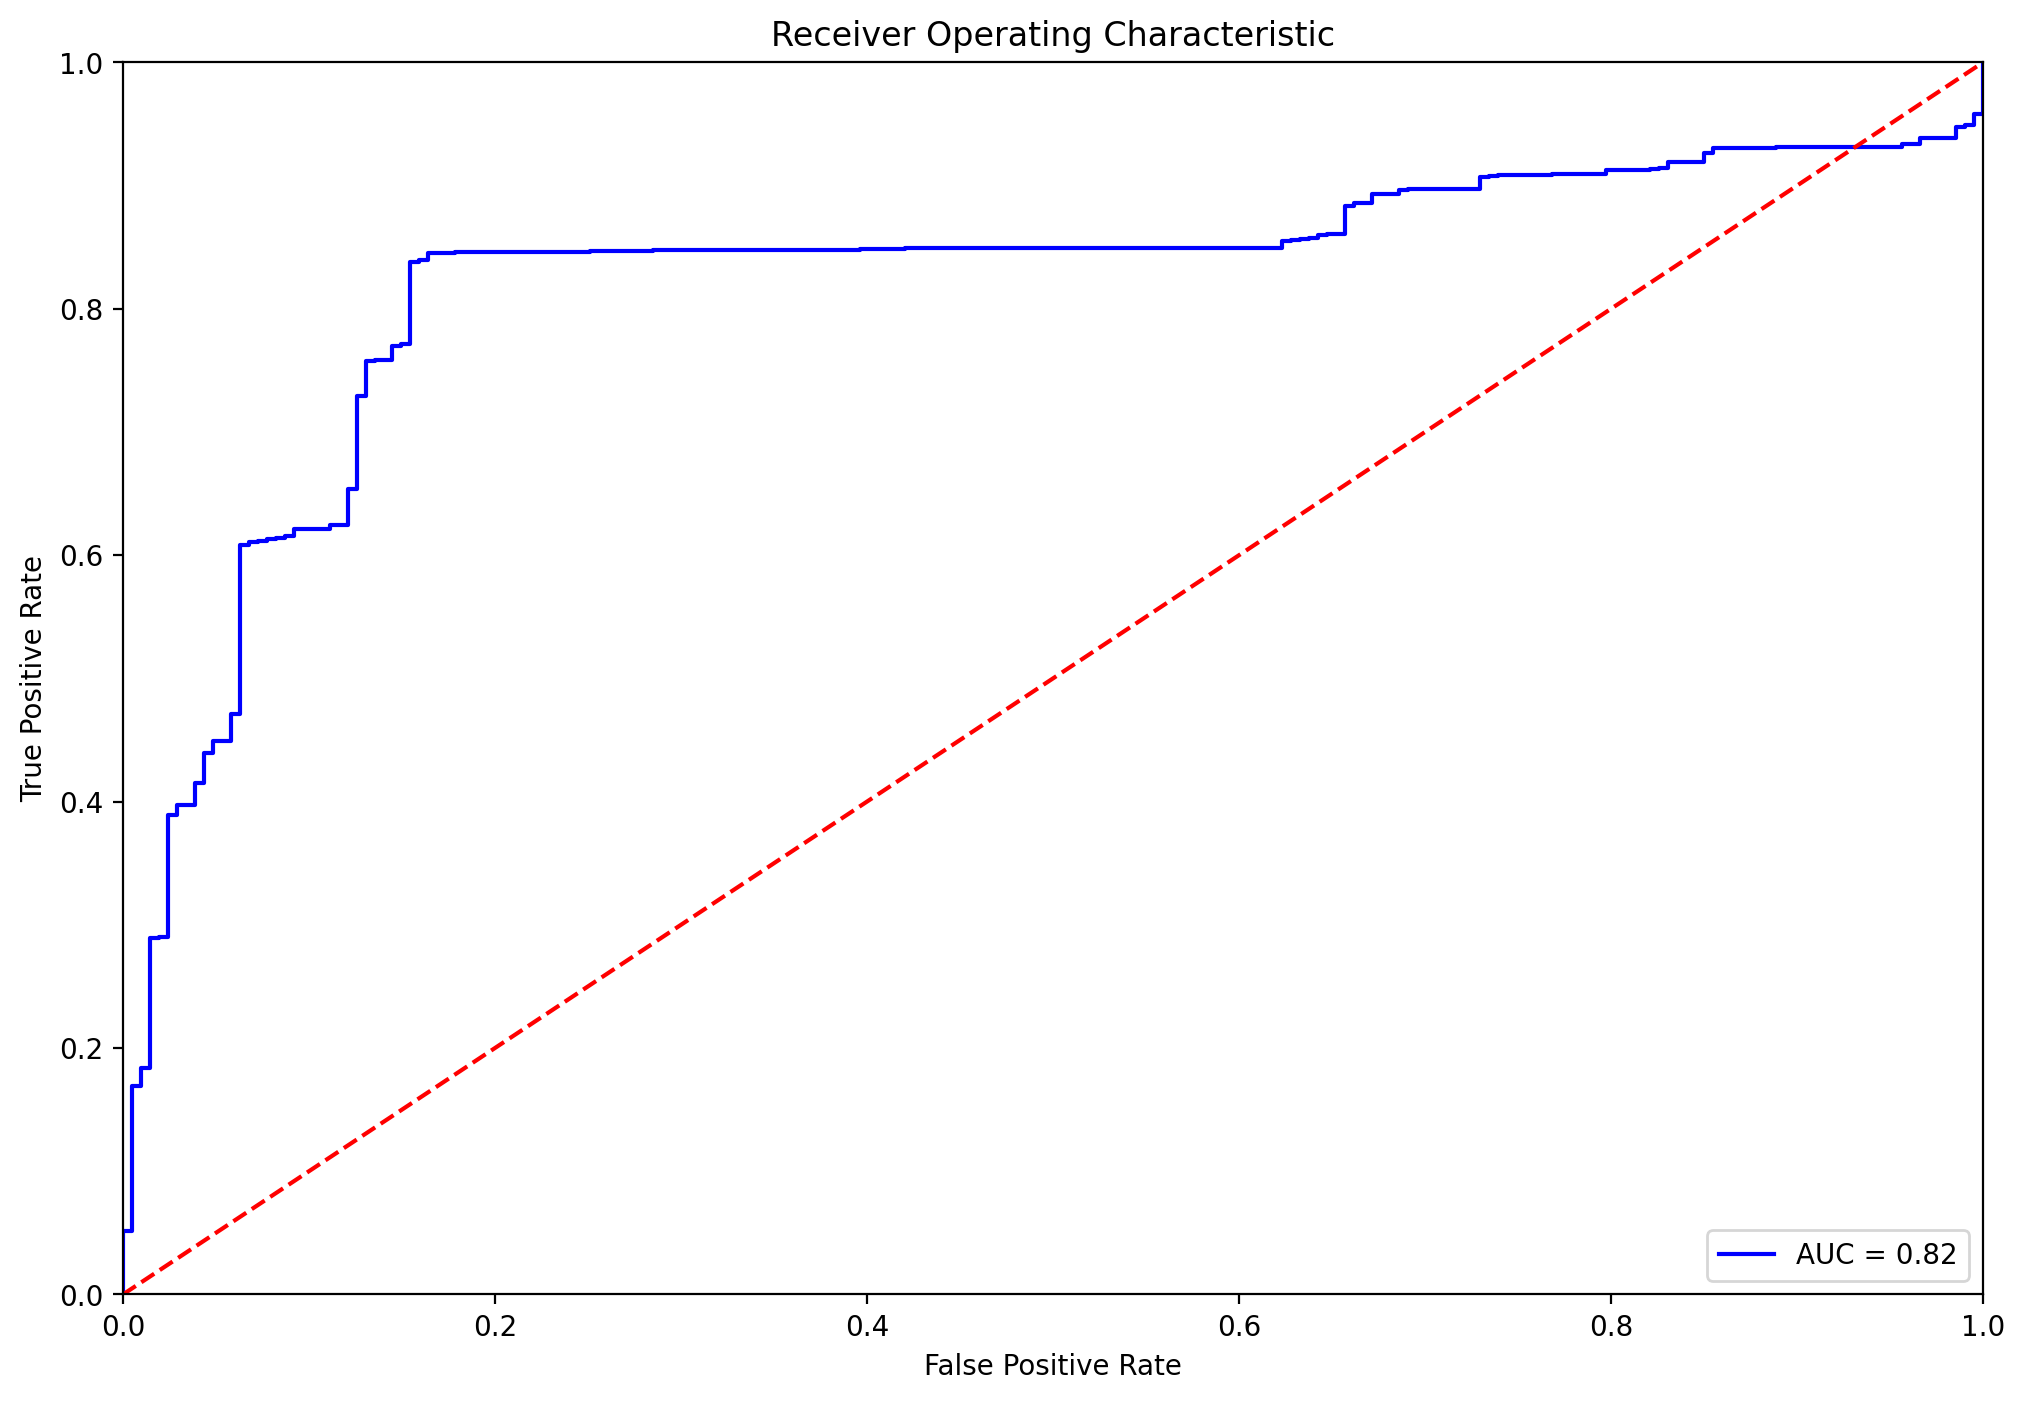

In [60]:
create_aucroc(model_svm, X_test_svm[:200_000], Y_test_svm[:200_000])

We can see that the one class SVM has better results to classify fraudulent traffic compare to the Isolation Forest. However the classification
of the non fraudulent traffic is worst.

### XGBoost

In [61]:
X_feature_xgboost = pd.concat([X_numerical, X_cat_onehot, X_numcat], axis=1)
X_train_xgboost, X_test_xgboost, Y_train_xgboost, Y_test_xgboost = train_test_split(X_feature_xgboost[:2_000_000],
                                                                                    Y[:2_000_000], test_size=0.2, random_state=3)

In [62]:
evalset = [(X_train_xgboost, Y_train_xgboost), (X_test_xgboost, Y_test_xgboost)]
weight = (Y == 0).sum() / (1.0 * (Y == 1).sum())

In [63]:
clf = xgb.XGBClassifier(max_depth=6, scale_pos_weight=weight, n_estimators=100,
                        n_jobs=6, verbosity=0, objective="binary:logistic").fit(X_train_xgboost, Y_train_xgboost, eval_set=evalset)

[0]	validation_0-logloss:0.47825	validation_1-logloss:0.47825
[1]	validation_0-logloss:0.34929	validation_1-logloss:0.34881
[2]	validation_0-logloss:0.26750	validation_1-logloss:0.26736
[3]	validation_0-logloss:0.21334	validation_1-logloss:0.21296
[4]	validation_0-logloss:0.17531	validation_1-logloss:0.17414
[5]	validation_0-logloss:0.14520	validation_1-logloss:0.14417
[6]	validation_0-logloss:0.12525	validation_1-logloss:0.12395
[7]	validation_0-logloss:0.10770	validation_1-logloss:0.10704
[8]	validation_0-logloss:0.08869	validation_1-logloss:0.08820
[9]	validation_0-logloss:0.07104	validation_1-logloss:0.07026
[10]	validation_0-logloss:0.05687	validation_1-logloss:0.05617
[11]	validation_0-logloss:0.04619	validation_1-logloss:0.04554
[12]	validation_0-logloss:0.04106	validation_1-logloss:0.04088
[13]	validation_0-logloss:0.03497	validation_1-logloss:0.03490
[14]	validation_0-logloss:0.03204	validation_1-logloss:0.03201
[15]	validation_0-logloss:0.02931	validation_1-logloss:0.02938
[1

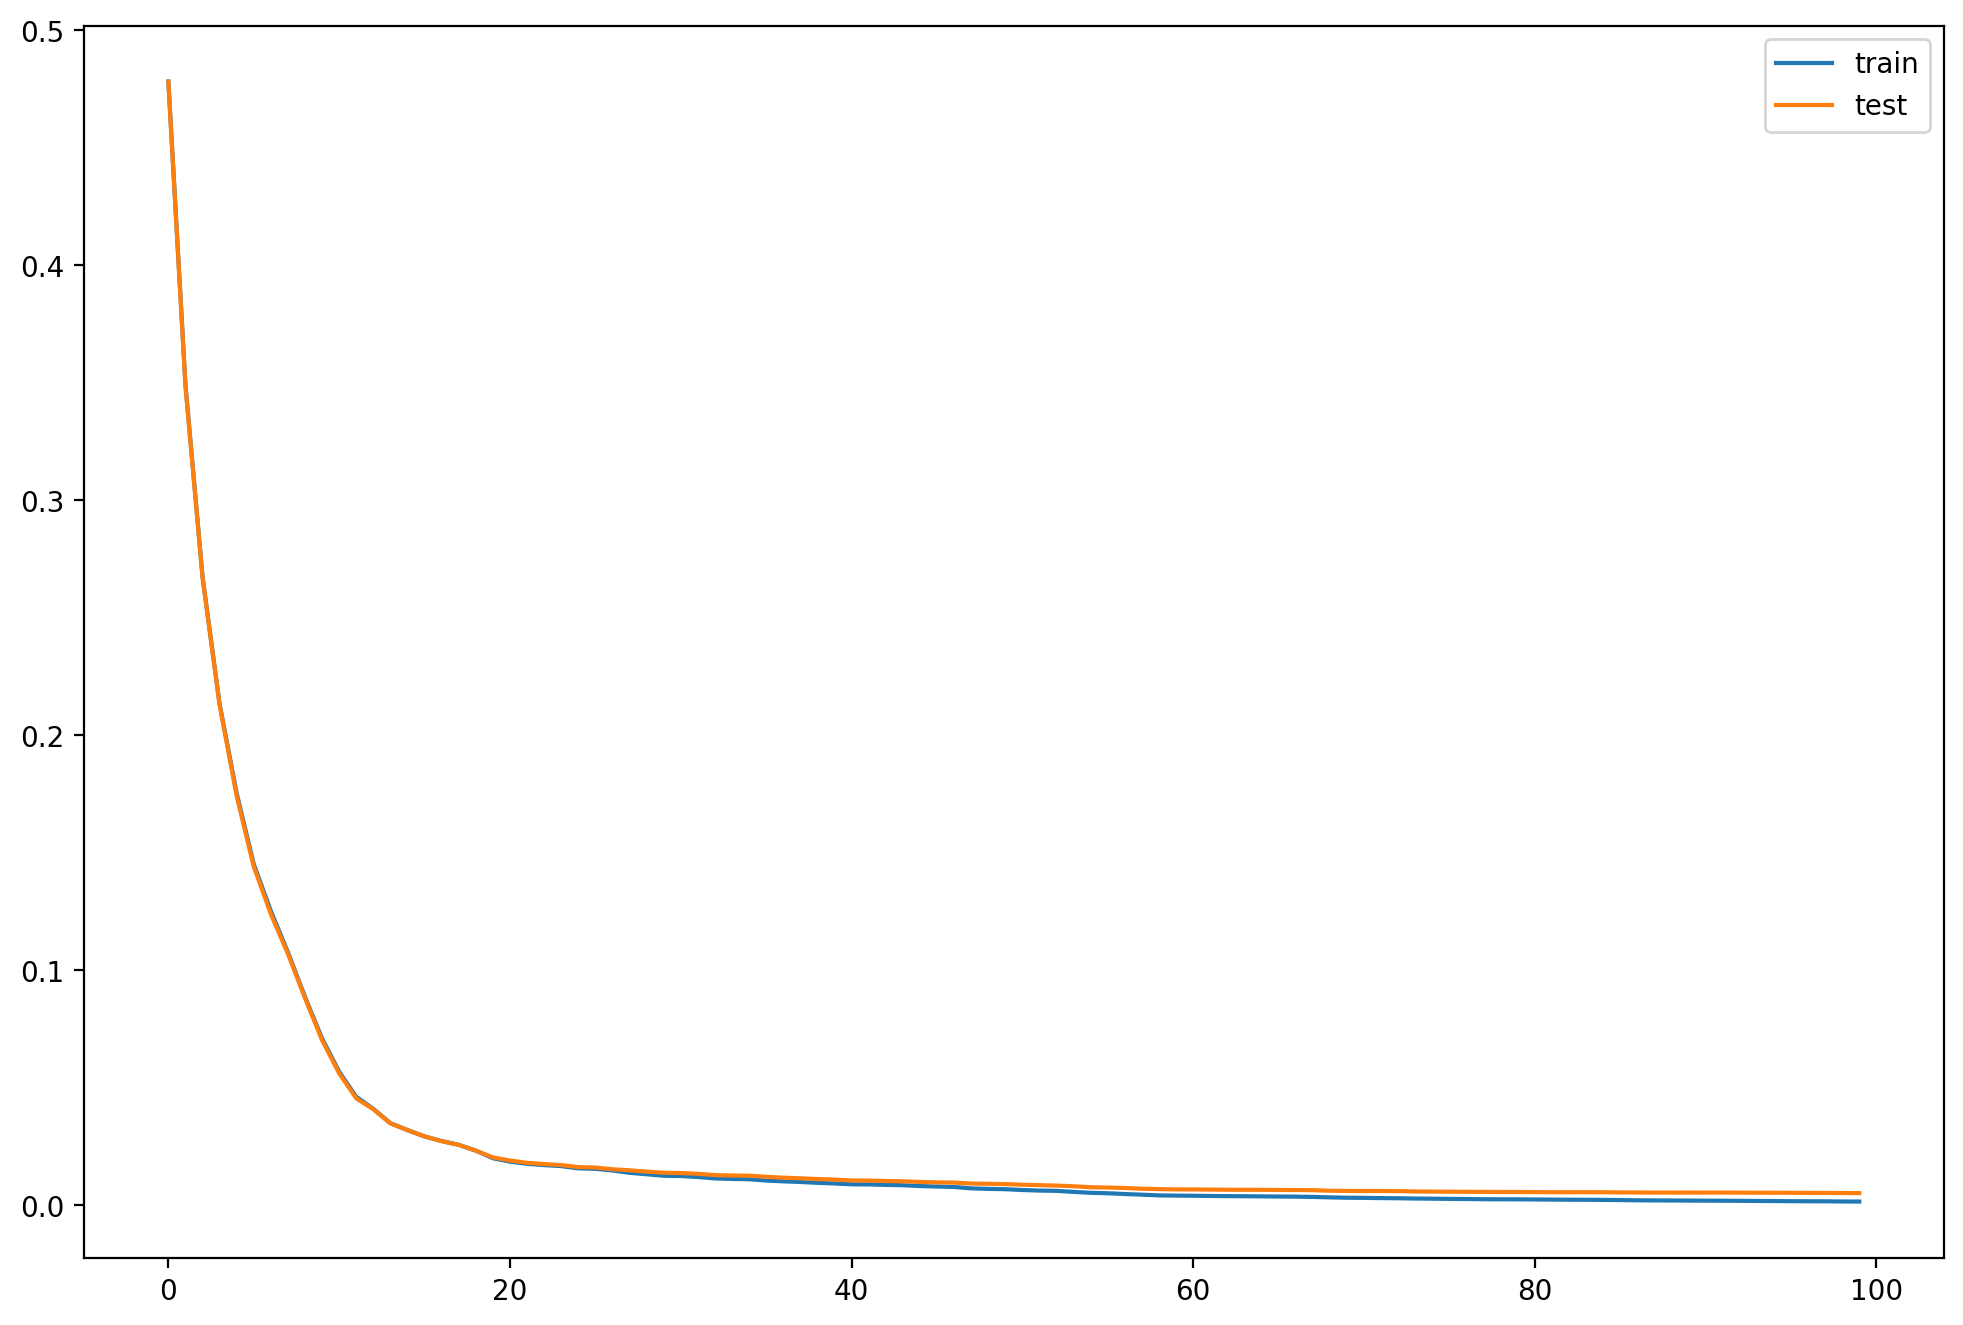

In [64]:
results = clf.evals_result()
plt.figure(figsize=(12, 8))
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.show()

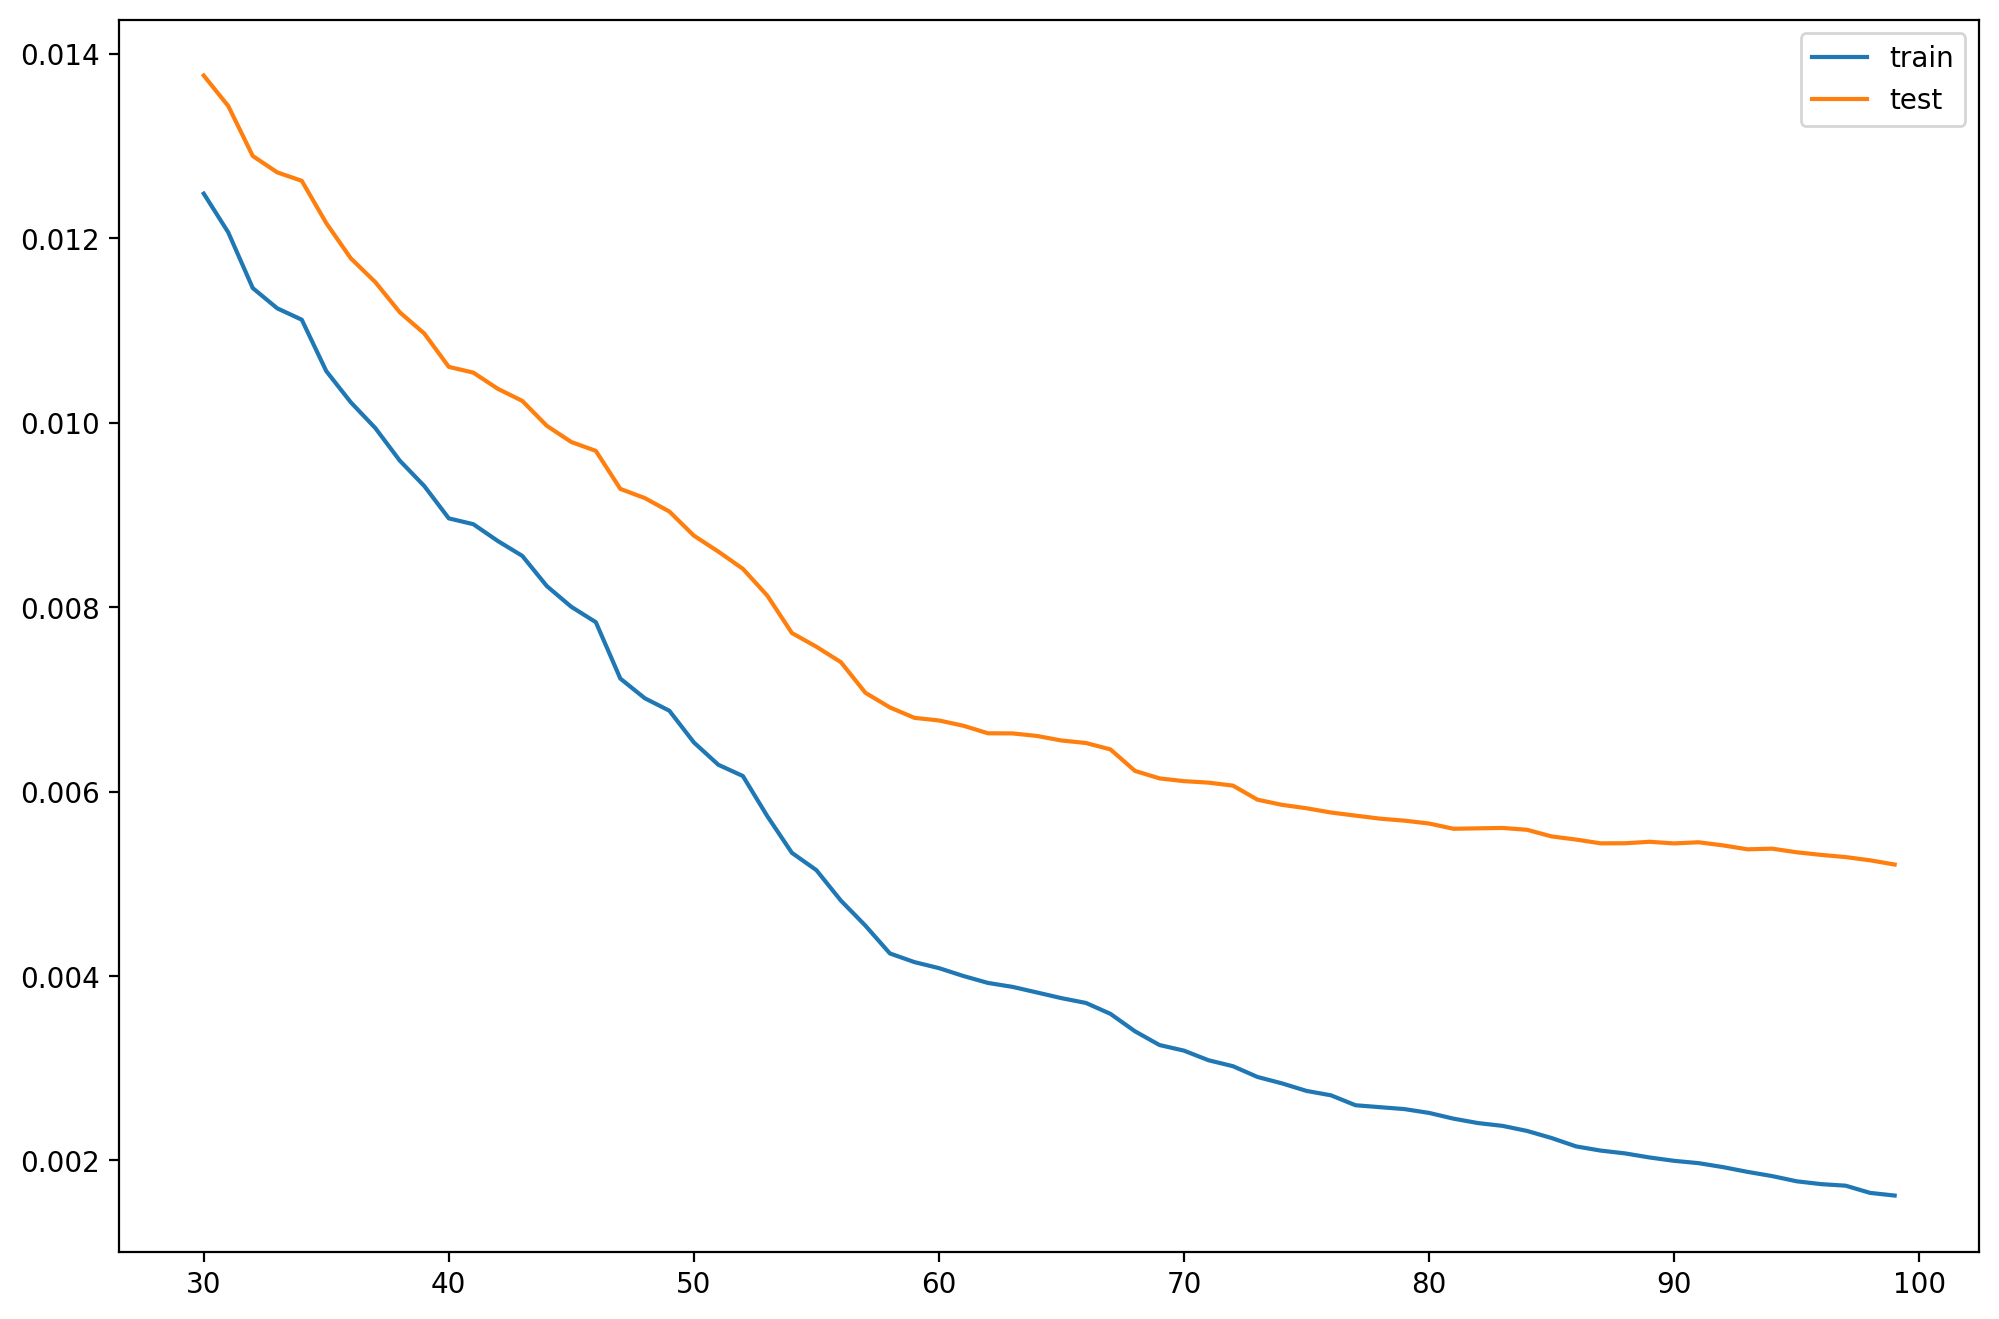

In [65]:
results = clf.evals_result()
plt.figure(figsize=(12, 8))
plt.plot(range(30, 100), results['validation_0']['logloss'][30:], label='train')
plt.plot(range(30, 100), results['validation_1']['logloss'][30:], label='test')
plt.legend()
plt.show()

In [66]:
y_pred_xgboost_test = clf.predict_proba(X_test_xgboost)
y_pred_xgboost_train = clf.predict_proba(X_train_xgboost)

In [67]:
plot_metrics(np.where(y_pred_xgboost_train[:, 1] < 0.5, 0, 1), Y_train_xgboost)

################### Metrics ###################

Number of values: 86092
Number of non fraudulent values: 85145 | 98.90001% of the data
Number of fraudulent values: 947 | 1.09999% of the data

Number of correct classification: 86051 | Accuracy: 99.95238%
Number of non fraudulent values detected: 85104
| Percentage of correct classification 98.85239% (True positive in total number of values)
| Accuracy of the class: 99.95185% (True positive in non fraudulent values count)

Number of fraudulent values detected: 947
| Percentage of correct classification 1.09999% (True negative in total number of values)
| Accuracy of the class: 100.0% (True negative in fraudulent values count)

Number of false negative: 41
| Percentage of false negative: 0.04762% (false negative in total number of values)

Number of false positive: 0
| Percentage of false posivive: 0.0% (false positive in total number of values)

Balanced accuracy score: 99.97592%
Precision: 0.9585
Recall: 1.0
R2: 0.95622
F1 score: 0.978

In [68]:
plot_metrics(np.where(y_pred_xgboost_test[:, 1] < 0.5, 0, 1), Y_test_xgboost)

################### Metrics ###################

Number of values: 21523
Number of non fraudulent values: 21316 | 99.03824% of the data
Number of fraudulent values: 207 | 0.96176% of the data

Number of correct classification: 21498 | Accuracy: 99.88385%
Number of non fraudulent values detected: 21297
| Percentage of correct classification 98.94996% (True positive in total number of values)
| Accuracy of the class: 99.91087% (True positive in non fraudulent values count)

Number of fraudulent values detected: 201
| Percentage of correct classification 0.93388% (True negative in total number of values)
| Accuracy of the class: 97.10145% (True negative in fraudulent values count)

Number of false negative: 19
| Percentage of false negative: 0.08828% (false negative in total number of values)

Number of false positive: 6
| Percentage of false posivive: 0.02788% (false positive in total number of values)

Balanced accuracy score: 98.50616%
Precision: 0.91364
Recall: 0.97101
R2: 0.87805
F1 

In [69]:
def plotXGBoost(clf):
    fig = plt.figure(figsize=(14, 9))
    ax = fig.add_subplot(111)
    
    ax = xgb.plot_importance(clf, height=1, importance_type='gain', ax=ax)
    
    plt.plot()

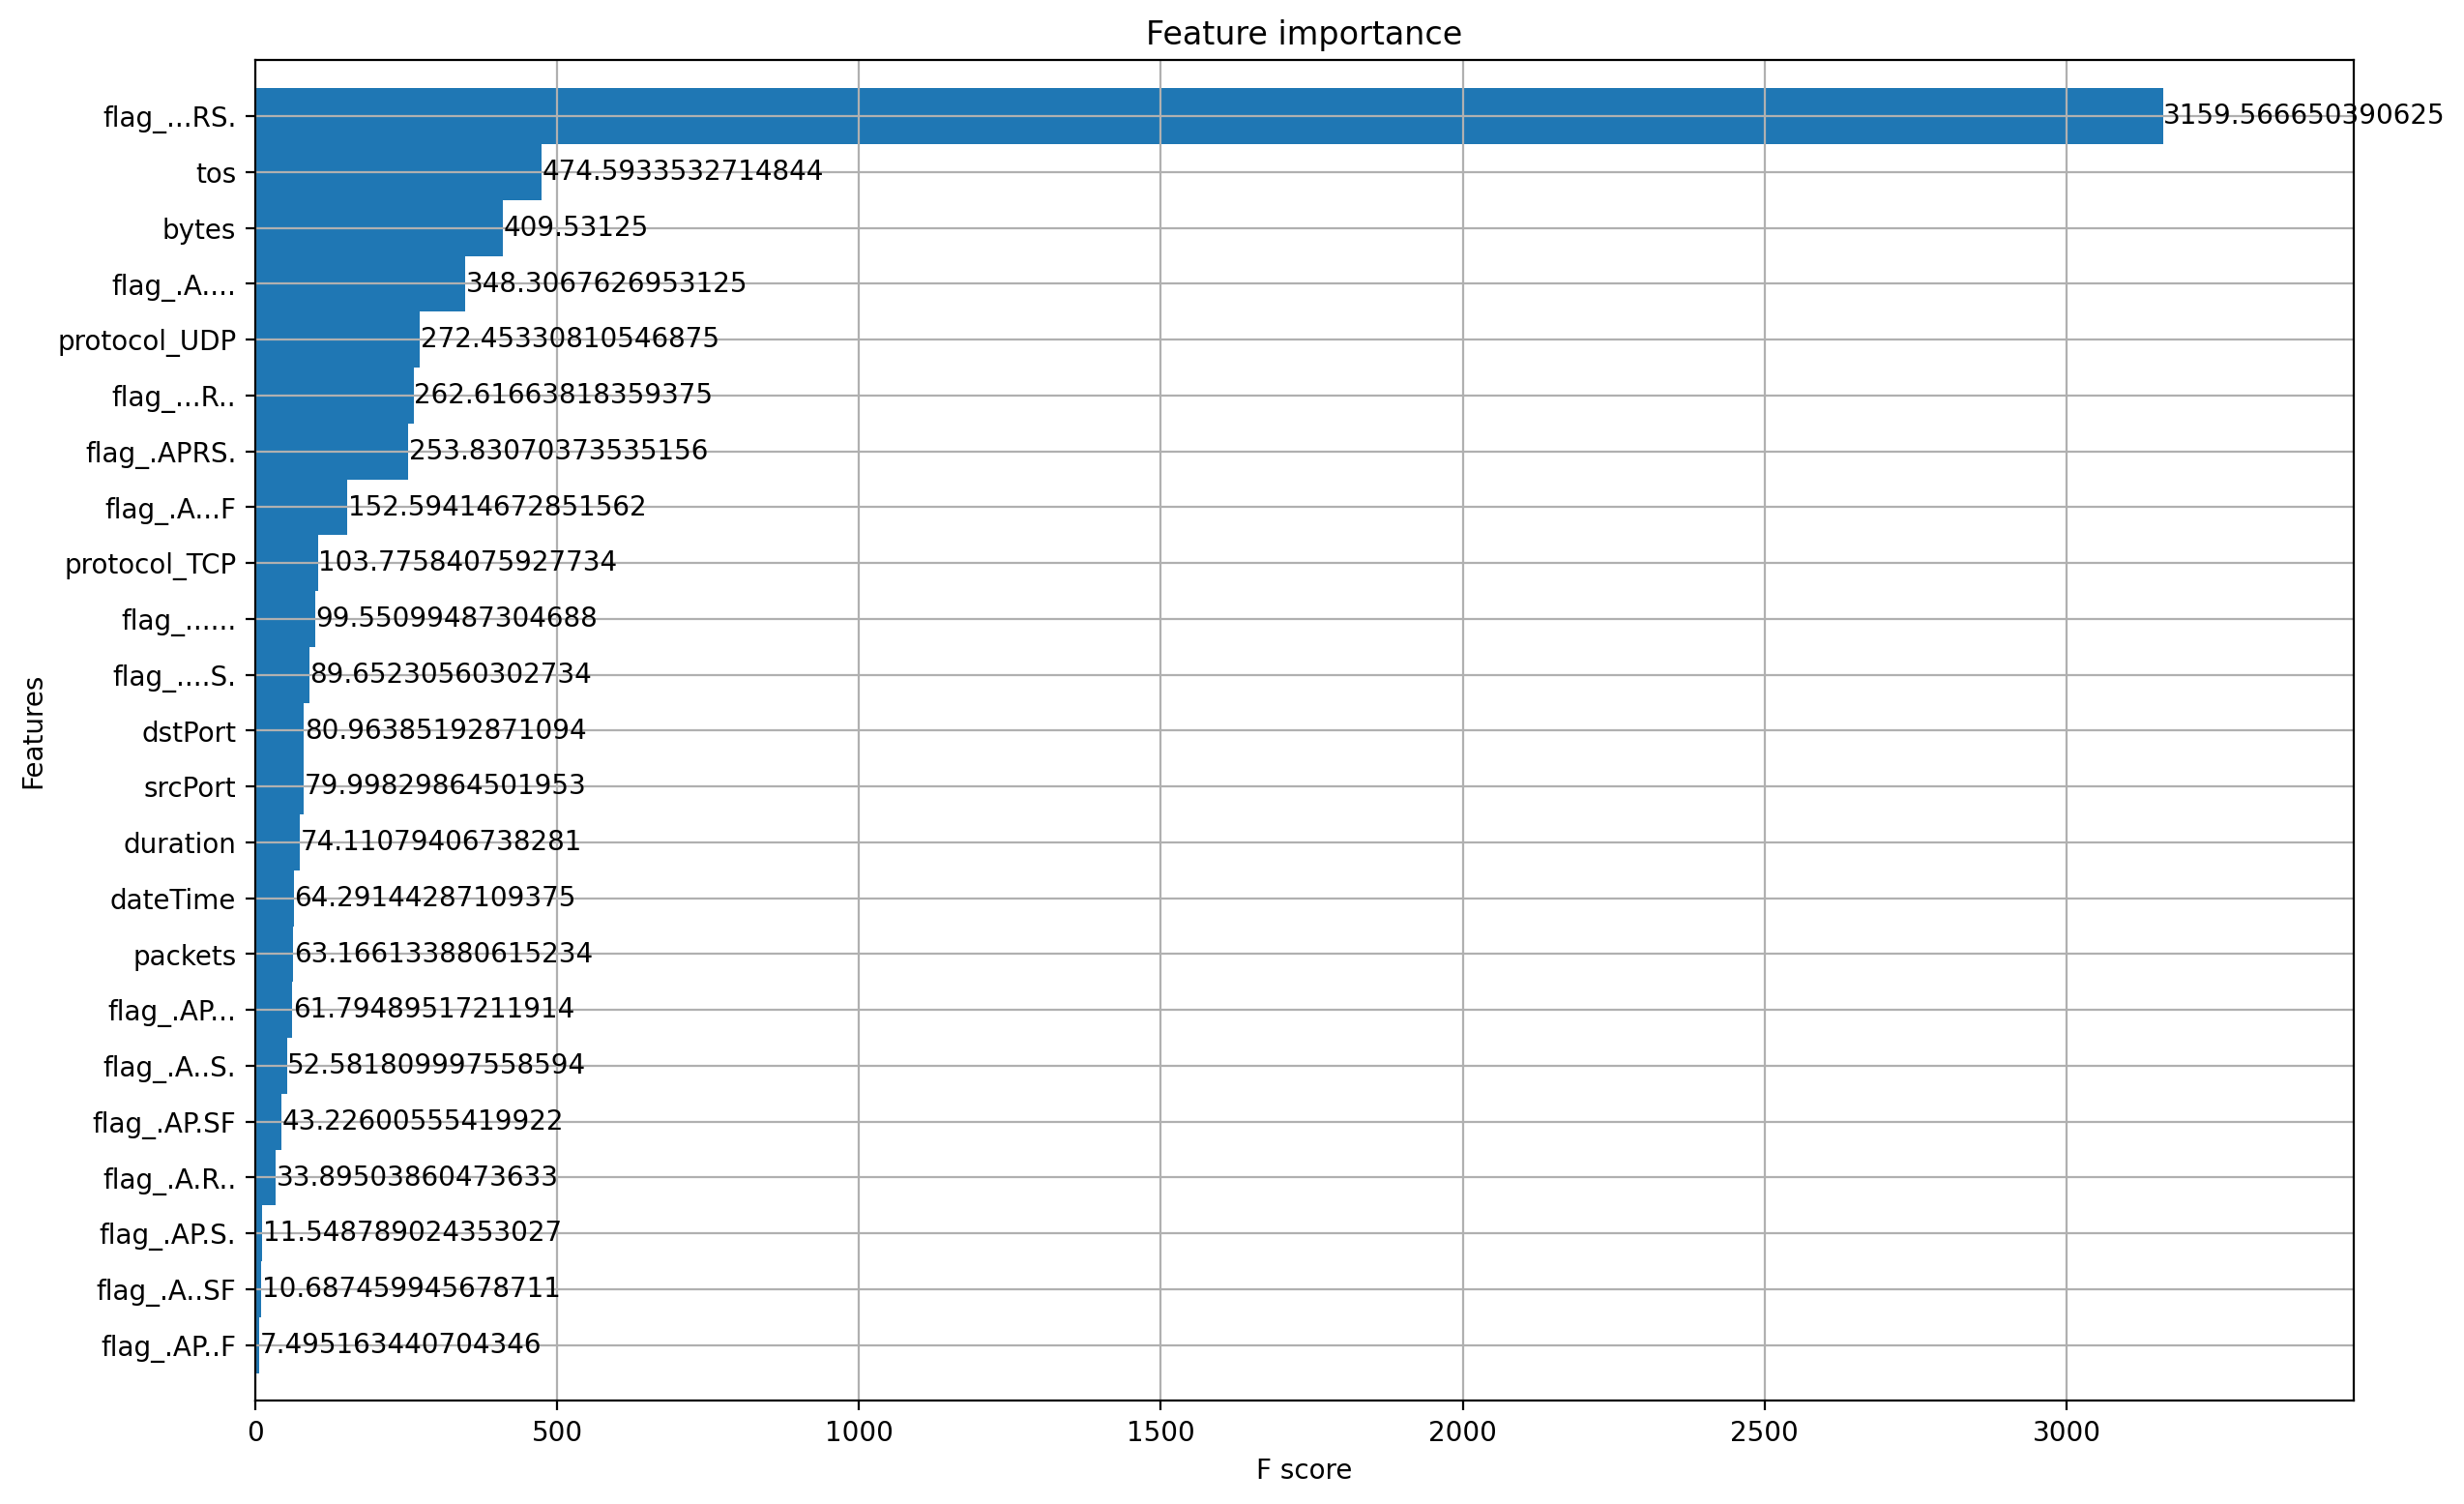

In [70]:
plotXGBoost(clf)

In [71]:
def plotXGBoost_tree(clf):
    fig = plt.figure(figsize=(20, 60))
    ax = fig.add_subplot(111)
    
    ax = xgb.plot_tree(clf, ax=ax, rankdir='LR')
    
    plt.plot()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

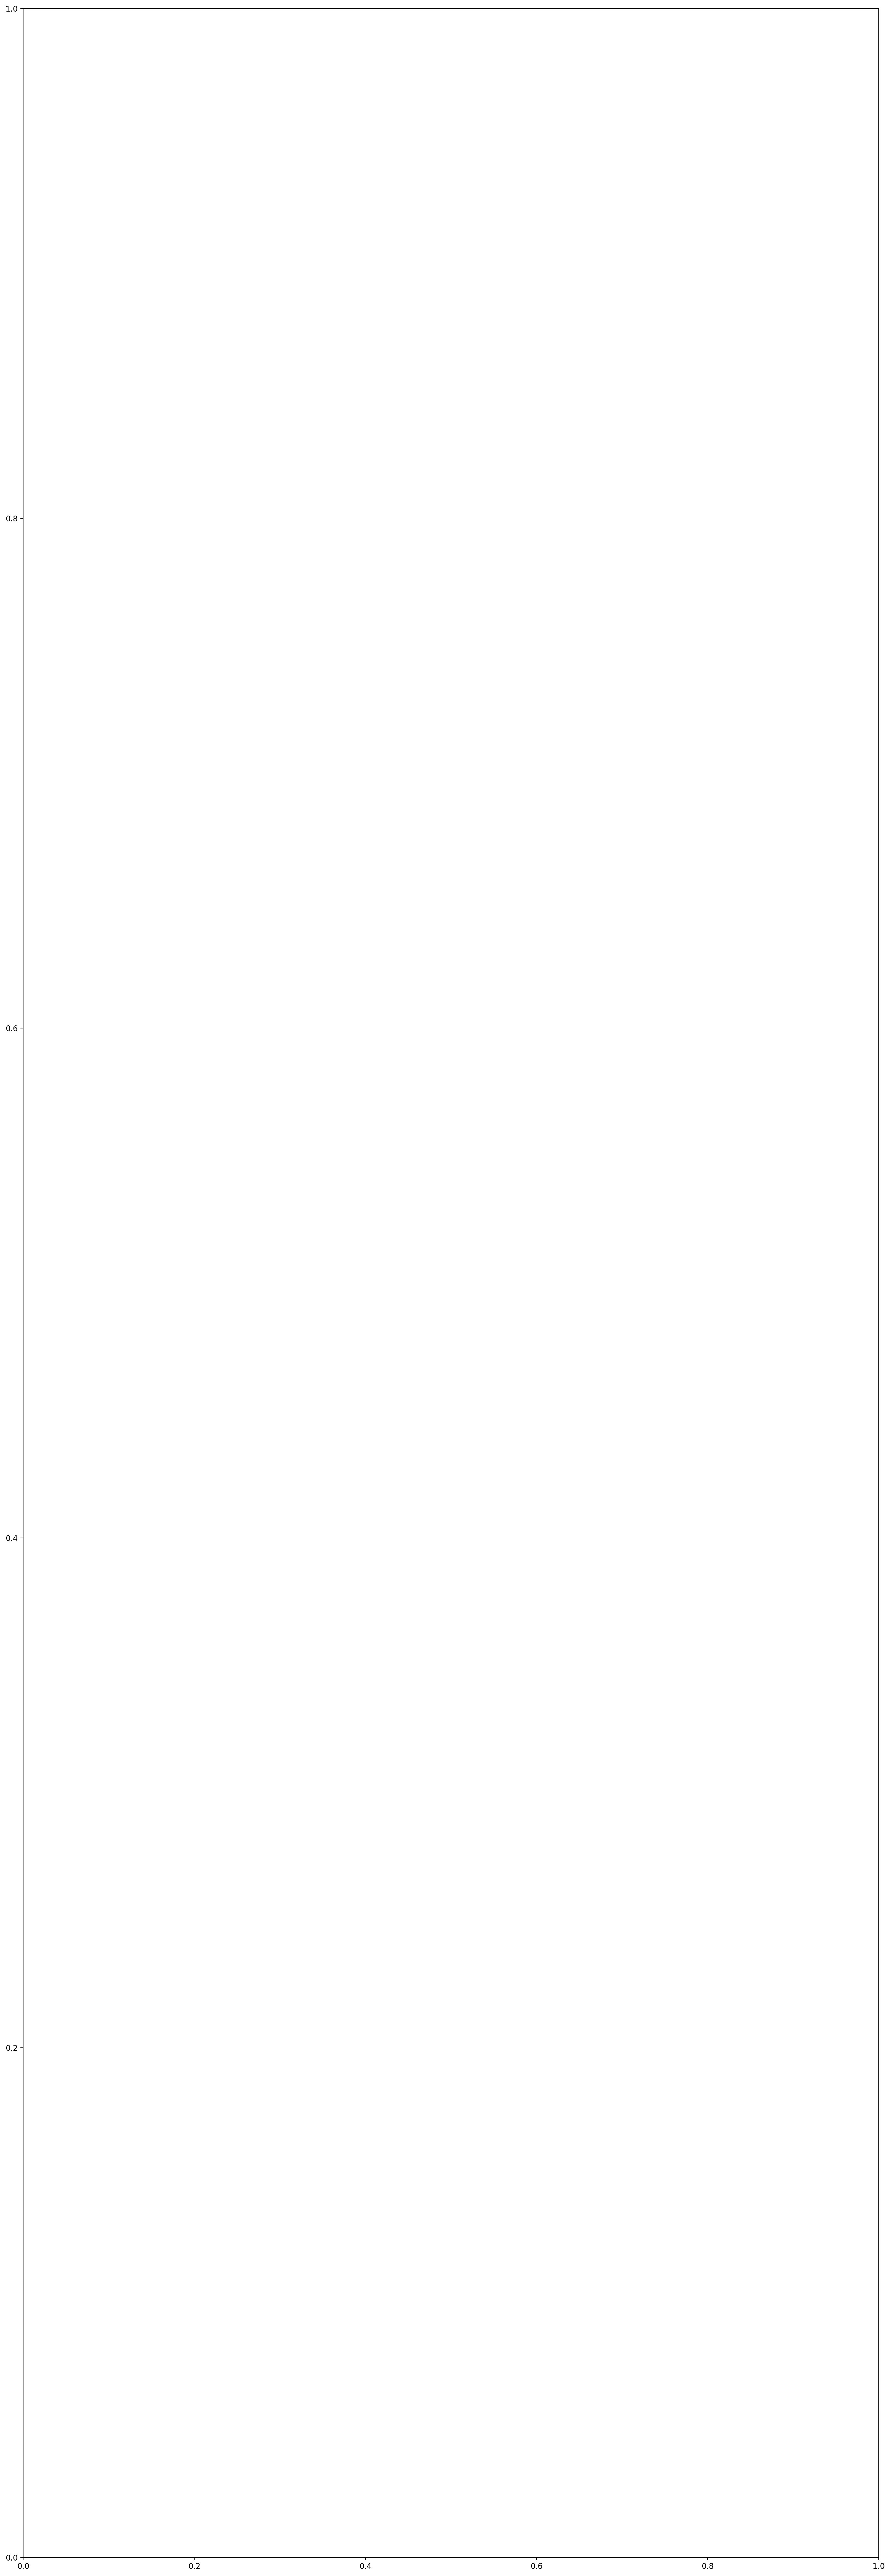

In [72]:
#plotXGBoost_tree(clf)
plotXGBoost_tree(clf)
plt.show()